<a href="https://colab.research.google.com/github/Jules-gatete/Mission_Capstone/blob/main/Mission_Capstone__ML_Model_Development_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#UmutiSafe: “Classification and Guidance System for Safe Household Disposal of Leftover and Expired Medicines with CHW Integration in Rwanda”

Consolidated Machine Learning Model Development Notebook

##Author: **Jules Gatete**

###Institution: ***African Leadership University***

####Date: **September 2025**

This notebook implements a machine learning system for medecine/pharmaceticsl disposal classification

###OVERVIEW:
---------
1. Problem Statement: 90%+ of Rwandan households dispose of medicines improperly
2. Solution: ML-based classification system for disposal categories and risk assessment
3. Approach: Multi-model ensemble with TF-IDF + Word2Vec features
4. Output: Automated disposal guidelines with step-by-step procedures

##MODELS IMPLEMENTED:
-------------------
- Random Forest Classifier (with hyperparameter tuning)
- Decision Tree Classifier
- Regression Tree (for category prediction)
- Gradient Boosting Classifier
- Multi-Layer Perceptron Neural Network (with GridSearchCV)

##FEATURES:
---------
- Afeature engineering (TF-IDF,  text statistics)
- Class imbalance handling (SMOTE, class weights)
- OCR integration for medicine label recognition
-  disposal guidelines generation


#  Install and Import Required Libraries


 Installing and import all required libraries for the project
- Machine learning: scikit-learn, imbalanced-learn
- Deep learning: TensorFlow/Keras (optional)
- NLP: gensim (Word2Vec), NLTK
- OCR: EasyOCR, OpenCV
- Visualization: matplotlib, seaborn
- Data processing: pandas, numpy



#MEDICINE DISPOSAL CATEGORY CLASSIFICATION MODEL


In [11]:
# Install required libraries (Uncomment if running for the first time)
!pip install pandas numpy scikit-learn matplotlib seaborn beautifulsoup4 requests lxml joblib

# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import joblib
import datetime

print(" Libraries successfully imported.")


 Libraries successfully imported.


In [12]:
!pip install easyocr opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 19.7 MB/s eta 0:00:00


In [13]:
# Import Core Libraries

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import warnings
from datetime import datetime

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score,
                             ConfusionMatrixDisplay, mean_squared_error, r2_score)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA

# Imbalanced Learning
from imblearn.over_sampling import SMOTE

# NLP and Text Processing
# Temporarily comment out gensim import due to compatibility issues
# from gensim.models import Word2Vec
from difflib import SequenceMatcher

# OCR
import easyocr
import cv2
from PIL import Image

# Configure environment
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("All libraries imported successfully.")
print(f"NumPy version: {np.__version__}")


All libraries imported successfully.
NumPy version: 2.0.2


# SECTION 2: DATA LOADING AND INITIAL EXPLORATION


 Loading the Rwanda FDA medicines dataset and perform initial exploration:
- Load CSV data
- Display basic statistics
- Check for missing values
- Identify key hazardous drug categories
- Perform initial data quality assessment


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Rwanda FDA Human Medicinal Products Register Scraper

!pip install requests beautifulsoup4 pandas lxml --quiet

import requests
from bs4 import BeautifulSoup
import pandas as pd

# Fetch the webpage
url = "https://rwandafda.gov.rw/human-medicinal-products-register/"
try:
    response = requests.get(url)
    response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)
except requests.exceptions.RequestException as e:
    print(f"Error fetching the webpage: {e}")
    # Optionally, exit or handle the error further
    exit()


soup = BeautifulSoup(response.text, "lxml")

# Find the table
table = soup.find("table")

if table is None:
    print("⚠️ No static HTML table found. The page might load data dynamically with JavaScript.")
    print("You may need Selenium or use the FDA API endpoint if available.")
else:
    header_cells = table.find('tr').find_all(['th', 'td'])
    headers = [th.get_text(strip=True) for th in header_cells]

    # Extract all data rows
    rows = []
    for tr in table.find_all("tr")[1:]:
        cols = [td.get_text(strip=True) for td in tr.find_all("td")]
        if cols:
            rows.append(cols)

    if not headers:
        print(" No headers found in the table.")
        if rows:
            headers = [f"Column {i+1}" for i in range(len(rows[0]))]
            print(f"Inferred {len(headers)} headers based on the first row's columns.")
        else:
            print("No data rows found either. Cannot create DataFrame.")
            exit()
    if not rows:
        print(" No data rows found in the table.")
        df = pd.DataFrame([], columns=headers)
    else:
        if len(headers) != len(rows[0]):
             print(f"Warning: Mismatch between number of headers ({len(headers)}) and number of columns in data rows ({len(rows[0])}).")
             if rows:
                headers = [f"Column {i+1}" for i in range(len(rows[0]))]
                print(f"Using inferred headers: {headers}")


        # Create a pandas DataFrame
        df = pd.DataFrame(rows, columns=headers)

    # Save as CSV
    save_path = "/content/drive/MyDrive/UmutiSafe/data/raw/rwanda_fda_medicines.csv"
    try:
        df.to_csv(save_path, index=False, encoding="utf-8-sig")
        print(f" Successfully scraped and saved the dataset to: {save_path}")
    except Exception as e:
        print(f"Error saving file to Google Drive: {e}")

 Successfully scraped and saved the dataset to: /content/drive/MyDrive/UmutiSafe/data/raw/rwanda_fda_medicines.csv


In [16]:
# Load the medicines dataset
df = pd.read_csv('/content/drive/MyDrive/UmutiSafe/data/raw/rwanda_fda_medicines.csv')
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

Dataset shape: (2321, 16)

First 5 rows:


,No.,Registration No.,Product Brand Name,Generic Name,Dosage Strength,Dosage Form,Pack Size,Packaging Type,Shelf Life,Manufacturer's Name,Manufacturer's Address,Manufacturer Country,Marketing Authorization Holder(MAH),Local Technical Representative(LTR),Registration Date,Expiry Date
0,1,Rwanda FDA-HMP-MA-0033,ILET B2,"Glimepiride, Metformin HCl","2mg, 500mg",Tablets,"Box Of 10, Box Of 30",ALU-PVC/PVDC BLISTER PACK,24 Months,MSN LABORATORIES PRIVATE LIMITED (Formulations...,"Plot No. 42, Anrich Industrial Estate, Bollara...",INDIA,MSN LABORATORIES PRIVATE LIMITED,ABACUS PHARMA (A) LTD,2020-09-07,2025-09-07
1,2,Rwanda FDA-HMP-MA-0021,BI-PRETERAX,"Peridopril Arginine, Indapamide","5mg, 1.25mg",Tablets,30 Film Coated Tablets,POLYPROPYLENE CONTAINER,36 Months,LES LABORATOIRES SERVIER,"905 ROUTE DE SARAN, 45520 GIDY, FRANCE",FRANCE,LES LABORATOIRES SERVIER,KIPHARMA LTD,2020-09-15,2025-09-15
2,3,Rwanda FDA-HMP-MA-0022,DIAMICRON MR,Gliclazide,60mg,Tablets,30 Film Coated Tablets,ALU-ALU BLISTER PACK,24 Months,LES LABORATOIRES SERVIER,"905 ROUTE DE SARAN, 45520 GIDY, FRANCE",FRANCE,LES LABORATOIRES SERVIER,KIPHARMA LTD,2020-09-15,2025-09-15
3,4,Rwanda FDA-HMP-MA-0023,EYLEA,Aflibercept,40mg/ml,Solution For Injection,1 Vial*2ml,TYPE 1 GLASS VIAL,24 Months,"RAGENERON PHARMACEUTICALS, VETTER PHARMA-FERT...","Inc.81 Columbia Turnpike, Rensselaer, New York...","USA, GERMANY",BAYER EAST AFRICA LIMITED,SURGIPHARM (RWANDA) LTD,2020-09-15,2025-09-15
4,5,Rwanda FDA-HMP-MA-0024,FLOXSAFE-400,Moxifloxacin,400mg,Tablets,3 Blisters Of 5 Tablets,PVC /PVDC BLISTER PACK,24 Months,MSN LABORATORIES PRIVATE LIMITED (Formulations...,"Plot No. 42, Anrich Industrial Estate, Bollara...",INDIA,MSN LABORATORIES PRIVATE LIMITED,ABACUS PHARMA (A) LTD,2020-09-15,2025-09-15


In [17]:
# Display basic information
print("\n" + "="*80)
print("COLUMN INFORMATION")
print("="*80)
print("Column names:")
# Assuming df is already loaded from scraping
print(df.columns.tolist())
print("\nData types:")
print(df.dtypes)


COLUMN INFORMATION
Column names:
['No.', 'Registration No.', 'Product Brand Name', 'Generic Name', 'Dosage Strength', 'Dosage Form', 'Pack Size', 'Packaging Type', 'Shelf Life', "Manufacturer's Name", "Manufacturer's Address", 'Manufacturer Country', 'Marketing Authorization Holder(MAH)', 'Local Technical Representative(LTR)', 'Registration Date', 'Expiry Date']

Data types:
No.                                     int64
Registration No.                       object
Product Brand Name                     object
Generic Name                           object
Dosage Strength                        object
Dosage Form                            object
Pack Size                              object
Packaging Type                         object
Shelf Life                             object
Manufacturer's Name                    object
Manufacturer's Address                 object
Manufacturer Country                   object
Marketing Authorization Holder(MAH)    object
Local Technical Represe

In [18]:
# Missing Value Analysis

print("MISSING VALUE ANALYSIS")

missing_summary = df.isnull().sum()
missing_pct = (missing_summary / len(df)) * 100

missing_df = pd.DataFrame({
    'Column': missing_summary.index,
    'Missing_Count': missing_summary.values,
    'Missing_Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print("\nColumns with missing values:")
    print(missing_df.to_string(index=False))
else:
    print("\nNo missing values detected.")


# Cell 2.3: Hazardous Drug Category Analysis
"""
Identify and count medicines in key hazardous categories using pattern matching.
This helps understand the risk distribution in the dataset.
"""

print("="*80)
print("HAZARDOUS DRUG CATEGORY ANALYSIS")
print("="*80)

# Define hazard patterns for key drug categories
hazard_patterns = {
    'Antineoplastic (Chemotherapy)': r'methotrexate|doxorubicin|cisplatin|fluorouracil|cyclophosphamide|vincristine|paclitaxel',
    'Controlled Substances': r'morphine|fentanyl|buprenorphine|oxycodone|diazepam|methylphenidate',
    'Antibiotics (Fluoroquinolones)': r'ciprofloxacin|moxifloxacin|levofloxacin',
    'Beta-lactam Antibiotics': r'amoxicillin|penicillin|azithromycin|cephalexin',
    'Anticoagulants': r'warfarin|heparin|rivaroxaban'
}

hazard_counts = {}
for category, pattern in hazard_patterns.items():
    # Use column index '3' for 'Generic Name'
    count = df['Generic Name'].str.contains(pattern, case=False, na=False).sum()
    hazard_counts[category] = count
    print(f"{category}: {count} medicines ({count/len(df)*100:.2f}%)")

print(f"\nTotal hazardous drugs identified: {sum(hazard_counts.values())}")
print(f"Percentage of dataset: {sum(hazard_counts.values())/len(df)*100:.2f}%")

MISSING VALUE ANALYSIS

Columns with missing values:
                             Column  Missing_Count  Missing_Percentage
                     Packaging Type             11            0.473934
             Manufacturer's Address              5            0.215424
                         Shelf Life              3            0.129255
                       Generic Name              2            0.086170
                          Pack Size              1            0.043085
               Manufacturer Country              1            0.043085
Local Technical Representative(LTR)              1            0.043085
HAZARDOUS DRUG CATEGORY ANALYSIS
Antineoplastic (Chemotherapy): 11 medicines (0.47%)
Controlled Substances: 17 medicines (0.73%)
Antibiotics (Fluoroquinolones): 43 medicines (1.85%)
Beta-lactam Antibiotics: 99 medicines (4.27%)
Anticoagulants: 26 medicines (1.12%)

Total hazardous drugs identified: 196
Percentage of dataset: 8.44%


# SECTION 3: DATA CLEANING AND PREPROCESSING
 Cleaning and preprocessing the dataset:
- Handle missing values with appropriate imputation strategies
- Standardize text fields
- Remove duplicates if any
- Validate data integrity

In [19]:
# Data Cleaning

print("DATA CLEANING PROCEDURES")

# Store original shape
original_shape = df.shape

# Fill missing values with appropriate defaults
df['Generic Name'] = df['Generic Name'].fillna('Unknown Ingredient')
df['Packaging Type'] = df['Packaging Type'].fillna('Standard Packaging')
df['Pack Size'] = df['Pack Size'].fillna('Standard Pack')
df['Shelf Life'] = df['Shelf Life'].fillna('24 Months')
df['Product Brand Name'] = df['Product Brand Name'].fillna('Unknown Brand')
df['Dosage Form'] = df['Dosage Form'].fillna('Unknown Form')


# Remove any duplicate entries
duplicates_before = df.duplicated().sum()
df = df.drop_duplicates()
duplicates_removed = duplicates_before - df.duplicated().sum()

print(f"Original dataset shape: {original_shape}")
print(f"Duplicates removed: {duplicates_removed}")
print(f"Final dataset shape: {df.shape}")
print(f"\nRemaining missing values: {df.isnull().sum().sum()}")

if df.isnull().sum().sum() == 0:
    print("\nData cleaning complete - no missing values remaining.")
else:
    print("\nWarning: Some missing values remain:")
    print(df.isnull().sum()[df.isnull().sum() > 0])

DATA CLEANING PROCEDURES
Original dataset shape: (2321, 16)
Duplicates removed: 0
Final dataset shape: (2321, 16)

Remaining missing values: 7

Manufacturer's Address                 5
Manufacturer Country                   1
Local Technical Representative(LTR)    1
dtype: int64


# SECTION 4: EXPLORATORY DATA ANALYSIS AND VISUALIZATION
Comprehensive exploratory data analysis with visualizations:
- Distribution analysis of key features
- Temporal analysis of medicine registrations
- Country of origin analysis
- Dosage form distribution
- Correlation analysis


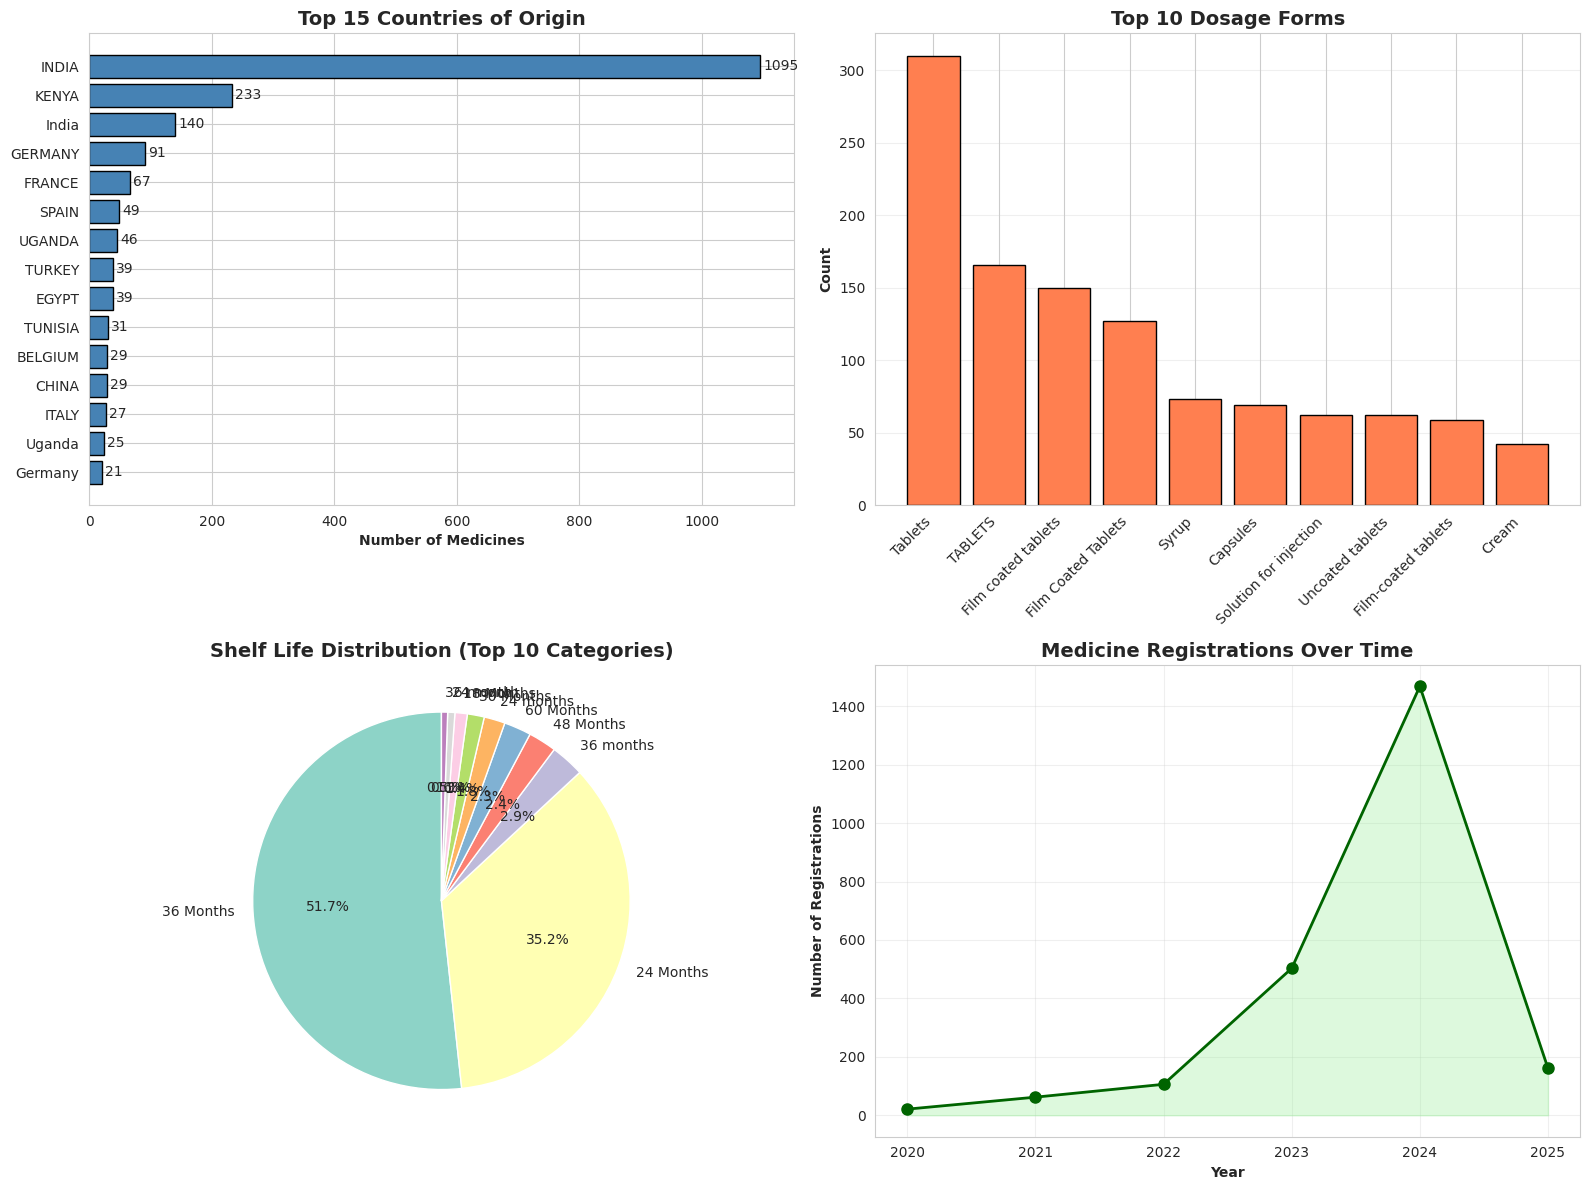

Dataset overview visualization saved as '01_dataset_overview.png'


In [20]:
# Dataset Overview Visualization
"""
Creating comprehensive visualization of dataset characteristics:
1. Top manufacturing countries
2. Dosage form distribution
3. Shelf life distribution
4. Registration timeline
"""
import matplotlib.pyplot as plt # Import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn as sns
import numpy as np # Import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Top 15 Manufacturing Countries
top_manufacturers = df['Manufacturer Country'].value_counts().head(15)
axes[0, 0].barh(range(len(top_manufacturers)), top_manufacturers.values, color='steelblue', edgecolor='black')
axes[0, 0].set_yticks(range(len(top_manufacturers)))
axes[0, 0].set_yticklabels(top_manufacturers.index)
axes[0, 0].set_xlabel('Number of Medicines', fontweight='bold')
axes[0, 0].set_title('Top 15 Countries of Origin', fontweight='bold', fontsize=14)
axes[0, 0].invert_yaxis()
for i, v in enumerate(top_manufacturers.values):
    axes[0, 0].text(v + 5, i, str(v), va='center')

# Plot 2: Top 10 Dosage Forms
top_dosage_forms = df['Dosage Form'].value_counts().head(10)
axes[0, 1].bar(range(len(top_dosage_forms)), top_dosage_forms.values, color='coral', edgecolor='black')
axes[0, 1].set_xticks(range(len(top_dosage_forms)))
axes[0, 1].set_xticklabels(top_dosage_forms.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Count', fontweight='bold')
axes[0, 1].set_title('Top 10 Dosage Forms', fontweight='bold', fontsize=14)
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Shelf Life Distribution
shelf_life_counts = df['Shelf Life'].value_counts().head(10)
colors_pie = plt.cm.Set3(range(len(shelf_life_counts)))
axes[1, 0].pie(shelf_life_counts.values, labels=shelf_life_counts.index,
               autopct='%1.1f%%', startangle=90, colors=colors_pie)
axes[1, 0].set_title('Shelf Life Distribution (Top 10 Categories)', fontweight='bold', fontsize=14)

# Plot 4: Registration Timeline
df['Registration Date'] = pd.to_datetime(df['Registration Date'], errors='coerce')
df['Registration_Year'] = df['Registration Date'].dt.year
yearly_registrations = df[df['Registration_Year'].notna()]['Registration_Year'].astype(int).value_counts().sort_index()
axes[1, 1].plot(yearly_registrations.index, yearly_registrations.values,
                marker='o', linewidth=2, markersize=8, color='darkgreen')
axes[1, 1].fill_between(yearly_registrations.index, yearly_registrations.values, alpha=0.3, color='lightgreen')
axes[1, 1].set_xlabel('Year', fontweight='bold')
axes[1, 1].set_ylabel('Number of Registrations', fontweight='bold')
axes[1, 1].set_title('Medicine Registrations Over Time', fontweight='bold', fontsize=14)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/UmutiSafe/outputs/figures/01_dataset_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("Dataset overview visualization saved as '01_dataset_overview.png'")

CORRELATION ANALYSIS


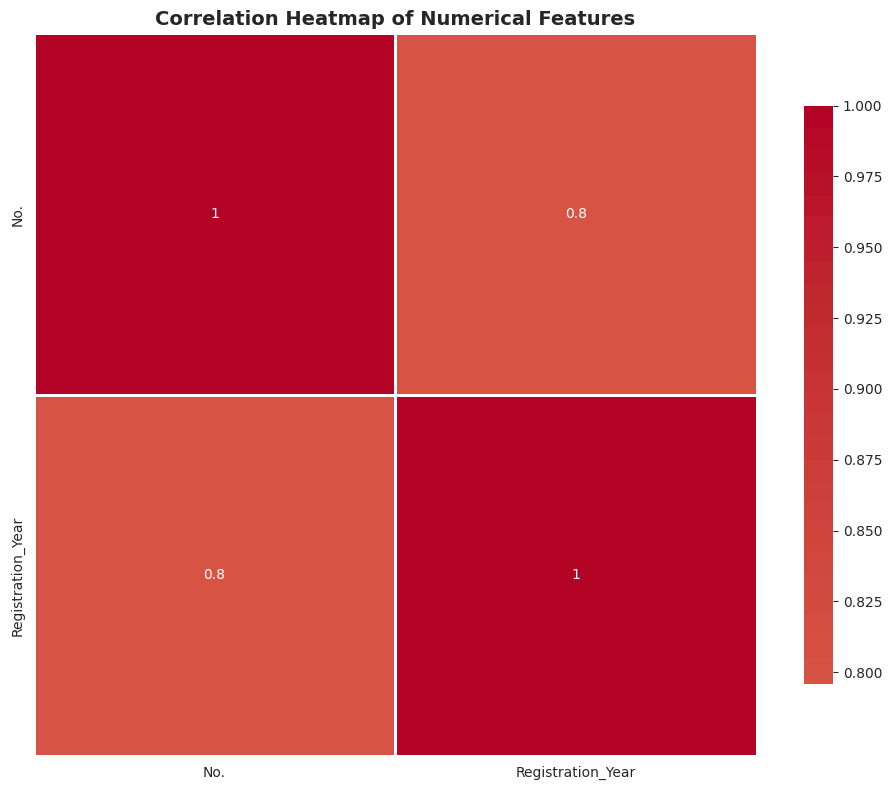

Correlation heatmap saved as '02_correlation_heatmap.png'


In [21]:
# Correlation Analysis
"""
Analyze correlations between numerical features.
Note: Most features are categorical, so correlation matrix may be limited.
"""
print("CORRELATION ANALYSIS")
print("="*80)

# Select numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns

if len(numerical_cols) > 1:
    corr_matrix = df[numerical_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Heatmap of Numerical Features', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/UmutiSafe/outputs/figures/02_correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Correlation heatmap saved as '02_correlation_heatmap.png'")
else:
    print("Insufficient numerical columns for correlation analysis.")
    print(f"Numerical columns found: {list(numerical_cols)}")

# SECTION 5: FEATURE ENGINEERING

 feature engineering for disposal classification:
- Disposal category classification (5 categories)
- Risk level assessment (HIGH/MEDIUM/LOW)
- Biodegradability detection
- Text feature extraction (word count, character count, special characters)
- Combined text features for NLP processing


In [22]:
# Feature Engineering Functions
"""
feature engineering functions for disposal classification.
These functions implement domain expertise in pharmaceutical waste management.
"""

def classify_dosage_form(dosage_form):
    """
    Classify medicine into disposal categories based on dosage form.

    Categories:
    1: Solids (Tablets, Capsules, Powders)
    2: Liquids (Solutions, Injections, Syrups)
    3: Semisolids (Creams, Ointments, Gels)
    4: Aerosols and Inhalers
    5: Biological Waste (Vaccines, Blood products)

    Args:
        dosage_form (str): Dosage form from medicine label

    Returns:
        int: Disposal category (1-5)
    """
    form = str(dosage_form).lower()

    if any(word in form for word in ['tablet', 'capsule', 'powder', 'granule', 'pill']):
        return 1  # Solids
    elif any(word in form for word in ['solution', 'injection', 'liquid', 'syrup', 'suspension', 'infusion', 'drop']):
        return 2  # Liquids
    elif any(word in form for word in ['cream', 'ointment', 'gel', 'paste', 'lotion', 'emulsion']):
        return 3  # Semisolids
    elif any(word in form for word in ['aerosol', 'inhaler', 'spray', 'mist']):
        return 4  # Aerosols
    elif any(word in form for word in ['vaccine', 'serum', 'blood', 'plasma']):
        return 5  # Biological
    else:
        return 1  # Default to solids

def assess_risk_level(ingredients):
    """
    Assess risk level based on active pharmaceutical ingredients.

    Risk Levels:
    HIGH: Antineoplastic, cytotoxic drugs (require specialized disposal)
    MEDIUM: Antibiotics, controlled substances (require careful disposal)
    LOW: General medicines (standard disposal procedures)

    Args:
        ingredients (str): Active ingredients list

    Returns:
        str: Risk level (HIGH/MEDIUM/LOW)
    """
    ingredients = str(ingredients).lower()

    # High-risk drugs (cytotoxic, antineoplastic)
    high_risk = ['methotrexate', 'doxorubicin', 'cisplatin', 'fluorouracil',
                 'cyclophosphamide', 'vincristine', 'paclitaxel', 'carboplatin',
                 'ifosfamide', 'cytarabine']

    # Medium-risk drugs (antibiotics, controlled substances)
    medium_risk = ['moxifloxacin', 'ciprofloxacin', 'penicillin', 'cephalosporin',
                   'amoxicillin', 'morphine', 'fentanyl', 'oxycodone', 'diazepam',
                   'warfarin', 'heparin', 'azithromycin']

    if any(drug in ingredients for drug in high_risk):
        return 'HIGH'
    elif any(drug in ingredients for drug in medium_risk):
        return 'MEDIUM'
    else:
        return 'LOW'

def check_biodegradable(ingredients):
    """
    Check if liquid medicine is biodegradable.
    Biodegradable medicines can be safely disposed in sewage systems after dilution.

    Args:
        ingredients (str): Active ingredients list

    Returns:
        bool: True if biodegradable, False otherwise
    """
    ingredients = str(ingredients).lower()

    biodegradable_substances = ['vitamin', 'glucose', 'saline', 'amino acid',
                                'sodium chloride', 'dextrose', 'cholecalciferol',
                                'ascorbic acid', 'folic acid', 'thiamine']

    return any(substance in ingredients for substance in biodegradable_substances)

def extract_text_features(text_data):
    """
    Extract statistical text features for ML model input.

    Features:
    - word_count: Number of words in text
    - char_count: Number of characters
    - special_chars: Number of special characters

    Args:
        text_data (pd.Series): Text data series

    Returns:
        pd.DataFrame: DataFrame with extracted features
    """
    features = {}
    features['word_count'] = text_data.apply(lambda x: len(str(x).split()))
    features['char_count'] = text_data.apply(lambda x: len(str(x)))
    features['special_chars'] = text_data.apply(lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', str(x))))

    return pd.DataFrame(features)

print("Feature engineering functions defined successfully.")

Feature engineering functions defined successfully.


## Apply Feature Engineering


In [23]:
# Apply Feature Engineering
"""
Applying feature engineering functions to create new features for ML models.
"""
import re

print("FEATURE ENGINEERING APPLICATION")
print("="*80)

# Create engineered features
df['disposal_category'] = df['Dosage Form'].apply(classify_dosage_form)
df['risk_level'] = df['Generic Name'].apply(assess_risk_level)
df['is_biodegradable'] = df['Generic Name'].apply(check_biodegradable)

# Combine text features for NLP processing
df['combined_text'] = (df['Product Brand Name'].astype(str) + ' ' +
                       df['Generic Name'].astype(str) + ' ' +
                       df['Dosage Form'].astype(str) + ' ' +
                       df['Packaging Type'].astype(str))

# Extract additional text features
text_features_df = extract_text_features(df['combined_text'])
df = pd.concat([df, text_features_df], axis=1)

print("Feature engineering complete.")
print("\nDisposal Category Distribution:")
print(df['disposal_category'].value_counts().sort_index())
print("\nRisk Level Distribution:")
print(df['risk_level'].value_counts())
print("\nBiodegradable Medicines:")
print(f"Biodegradable: {df['is_biodegradable'].sum()}")
print(f"Non-biodegradable: {(~df['is_biodegradable']).sum()}")

FEATURE ENGINEERING APPLICATION
Feature engineering complete.

Disposal Category Distribution:
disposal_category
1    1555
2     647
3     113
4       6
Name: count, dtype: int64

Risk Level Distribution:
risk_level
LOW       2148
MEDIUM     160
HIGH        13
Name: count, dtype: int64

Biodegradable Medicines:
Biodegradable: 100
Non-biodegradable: 2221


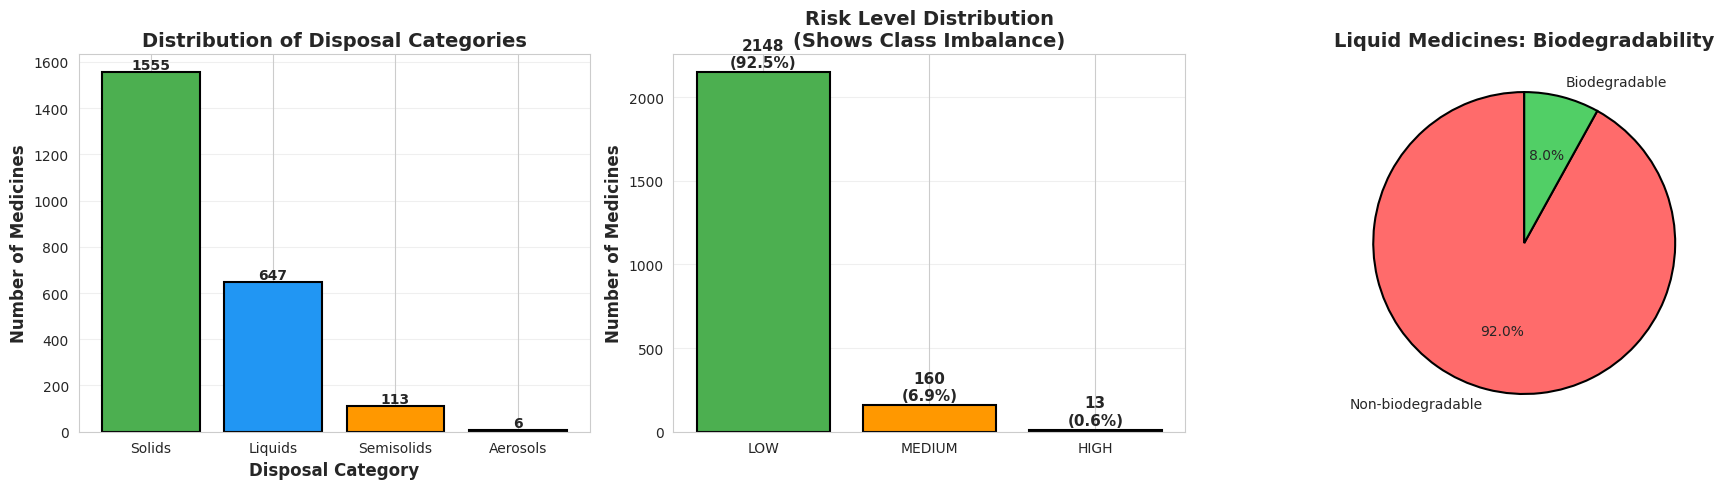

Feature distribution visualization saved as '03_feature_distribution.png'


In [24]:
# Feature Distribution Visualization
"""
This helps understand class imbalance and feature characteristics.
"""

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Disposal Categories Distribution
category_names = {1: 'Solids', 2: 'Liquids', 3: 'Semisolids', 4: 'Aerosols', 5: 'Biological'}
category_counts = df['disposal_category'].value_counts().sort_index()
colors_cat = ['#4CAF50', '#2196F3', '#FF9800', '#9C27B0', '#F44336']

bars1 = axes[0].bar(category_counts.index, category_counts.values,
                     color=colors_cat[:len(category_counts)], edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Disposal Category', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Medicines', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Disposal Categories', fontsize=14, fontweight='bold')
axes[0].set_xticks(category_counts.index)
axes[0].set_xticklabels([category_names.get(i, 'Other') for i in category_counts.index])
axes[0].grid(axis='y', alpha=0.3)
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Risk Levels Distribution
risk_counts = df['risk_level'].value_counts()
risk_colors = {'LOW': '#4CAF50', 'MEDIUM': '#FF9800', 'HIGH': '#F44336'}
bars2 = axes[1].bar(risk_counts.index, risk_counts.values,
                     color=[risk_colors[x] for x in risk_counts.index],
                     edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Number of Medicines', fontsize=12, fontweight='bold')
axes[1].set_title('Risk Level Distribution\n(Shows Class Imbalance)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, (label, count) in enumerate(risk_counts.items()):
    axes[1].text(i, count + 30, f'{count}\n({count/len(df)*100:.1f}%)',
                ha='center', fontweight='bold', fontsize=11)

# Plot 3: Biodegradability for Liquids
liquids_df = df[df['disposal_category'] == 2]
bio_counts = liquids_df['is_biodegradable'].value_counts()
labels_bio = ['Non-biodegradable', 'Biodegradable']
axes[2].pie(bio_counts.values, labels=labels_bio, autopct='%1.1f%%',
            colors=['#FF6B6B', '#51CF66'], startangle=90,
            wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
axes[2].set_title('Liquid Medicines: Biodegradability', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/UmutiSafe/outputs/figures/03_feature_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Feature distribution visualization saved as '03_feature_distribution.png'")

# SECTION 6: TEXT FEATURE EXTRACTION (TF-IDF )

 NLP feature extraction:
- TF-IDF vectorization for term importance
- Combined feature matrix for ML models

In [25]:
# TF-IDF Vectorization
"""
TF-IDF captures the importance of terms in the context of the entire corpus.
"""
import joblib # Import joblib

print("TF-IDF FEATURE EXTRACTION")
print("="*80)

# Fill missing values in combined_text
df['combined_text'] = df['combined_text'].fillna('')

# Create TF-IDF features
# max_features: Limit to top 100 features to reduce dimensionality
# ngram_range: Use unigrams and bigrams for better context
tfidf = TfidfVectorizer(max_features=100, ngram_range=(1, 2),
                        min_df=2, max_df=0.95)
X_text_tfidf = tfidf.fit_transform(df['combined_text'])

print(f"TF-IDF feature matrix shape: {X_text_tfidf.shape}")
print(f"\nTop 20 TF-IDF features:")
feature_names = tfidf.get_feature_names_out()
print(feature_names[:20])

# Calculate and display feature statistics
tfidf_array = X_text_tfidf.toarray()
feature_importance = np.mean(tfidf_array, axis=0)
top_indices = np.argsort(feature_importance)[-10:]

print("\nTop 10 most important features (by mean TF-IDF score):")
for idx in top_indices[::-1]:
    print(f"  {feature_names[idx]}: {feature_importance[idx]:.4f}")

# Save the fitted TF-IDF vectorizer
models_folder_path = '/content/drive/MyDrive/UmutiSafe/models'
tfidf_save_path = f"{models_folder_path}/tfidf_vectorizer.pkl"
try:
    joblib.dump(tfidf, tfidf_save_path)
    print(f"\nTF-IDF vectorizer saved successfully to: {tfidf_save_path}") # Added print
except Exception as e:
    print(f"Error saving TF-IDF vectorizer: {e}")

TF-IDF FEATURE EXTRACTION
TF-IDF feature matrix shape: (2321, 100)

Top 20 TF-IDF features:
['10' '100' '20' '50' '500' '500mg' '5mg' '5ml' 'acid' 'along'
 'along with' 'alu' 'alu alu' 'alu blister' 'alu pvc' 'aluminium'
 'aluminium foil' 'aluminum' 'amber' 'and']

Top 10 most important features (by mean TF-IDF score):
  tablets: 0.1142
  alu: 0.0954
  blister: 0.0727
  pvc: 0.0694
  mg: 0.0686
  and: 0.0605
  bp: 0.0572
  with: 0.0571
  aluminium: 0.0557
  in: 0.0533

TF-IDF vectorizer saved successfully to: /content/drive/MyDrive/UmutiSafe/models/tfidf_vectorizer.pkl


# SECTION 7: DATA SPLITTING AND PREPARATION
Preparing data for model training:
- Split into training and testing sets
- Encode target variables
- Verify data splits

In [26]:
# Train-Test Split
"""
Used stratified splitting to maintain class distribution.
"""
import joblib # Import joblib

print("="*80)
print("DATA SPLITTING")
print("="*80)

# Prepare target variables
y_category = df['disposal_category']
y_risk = df['risk_level']

# Encode target variables
le_category = LabelEncoder()
le_risk = LabelEncoder()
y_category_encoded = le_category.fit_transform(y_category)
y_risk_encoded = le_risk.fit_transform(y_risk)

# Create the feature matrix X by combining available features
# Assuming X_text_tfidf from cell 6.1 and text_features_df from cell 5.2 are available
X = np.hstack((X_text_tfidf.toarray(), text_features_df.values))


# Split data with stratification to maintain class distribution
X_train, X_test, y_cat_train, y_cat_test, y_risk_train, y_risk_test = train_test_split(
    X, y_category_encoded, y_risk_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_category_encoded
)

print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testing set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nTraining category distribution:")
for cat in np.unique(y_cat_train):
    count = np.sum(y_cat_train == cat)
    print(f"  Category {cat}: {count} samples ({count/len(y_cat_train)*100:.1f}%)")

print(f"\nTraining risk distribution:")
for risk_idx, risk_name in enumerate(le_risk.classes_):
    count = np.sum(y_risk_train == risk_idx)
    print(f"  {risk_name}: {count} samples ({count/len(y_risk_train)*100:.1f}%)")


# Save the fitted label encoders
models_folder_path = '/content/drive/MyDrive/UmutiSafe/models'
le_category_save_path = f"{models_folder_path}/le_category.pkl"
le_risk_save_path = f"{models_folder_path}/le_risk.pkl"

try:
    joblib.dump(le_category, le_category_save_path)
    print(f"\nCategory label encoder saved successfully to: {le_category_save_path}") # Added print
except Exception as e:
    print(f"Error saving category label encoder: {e}")

try:
    joblib.dump(le_risk, le_risk_save_path)
    print(f"Risk label encoder saved successfully to: {le_risk_save_path}") # Added print
except Exception as e:
    print(f"Error saving risk label encoder: {e}")

DATA SPLITTING
Training set size: 1856 samples (80.0%)
Testing set size: 465 samples (20.0%)

Training category distribution:
  Category 0: 1244 samples (67.0%)
  Category 1: 517 samples (27.9%)
  Category 2: 90 samples (4.8%)
  Category 3: 5 samples (0.3%)

Training risk distribution:
  HIGH: 11 samples (0.6%)
  LOW: 1720 samples (92.7%)
  MEDIUM: 125 samples (6.7%)

Category label encoder saved successfully to: /content/drive/MyDrive/UmutiSafe/models/le_category.pkl
Risk label encoder saved successfully to: /content/drive/MyDrive/UmutiSafe/models/le_risk.pkl


# SECTION 8: CLASS IMBALANCE HANDLING
Addressing class imbalance in risk level classification:
- Compute class weights
- Apply SMOTE (Synthetic Minority Over-sampling Technique)
- Visualize before/after distributions

In [27]:
#  Class Imbalance Analysis and SMOTE
"""
This is critical for HIGH-risk drug detection.
"""
print("CLASS IMBALANCE HANDLING")
print("="*80)

# Original distribution
print("Original Risk Level Distribution (Training Set):")
risk_train_decoded = le_risk.inverse_transform(y_risk_train)
risk_distribution = pd.Series(risk_train_decoded).value_counts()
print(risk_distribution)

# Calculate imbalance ratio
high_count = np.sum(risk_train_decoded == 'HIGH')
low_count = np.sum(risk_train_decoded == 'LOW')
if high_count > 0:
    imbalance_ratio = low_count / high_count
    print(f"\nImbalance Ratio (LOW:HIGH): {imbalance_ratio:.1f}:1")
else:
    print("\nWarning: No HIGH-risk drugs in training set")

# Compute class weights
classes_risk = np.unique(y_risk_train)
class_weights_risk = compute_class_weight('balanced',
                                          classes=classes_risk,
                                          y=y_risk_train)
class_weight_dict_risk = dict(zip(classes_risk, class_weights_risk))

print("\nComputed Class Weights:")
for cls, weight in class_weight_dict_risk.items():
    class_name = le_risk.inverse_transform([cls])[0]
    print(f"  {class_name}: {weight:.2f}x")

# Apply SMOTE
print("\nApplying SMOTE (Synthetic Minority Over-sampling)...")
k_neighbors = min(3, high_count - 1) if high_count > 1 else 1
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_balanced, y_risk_train_balanced = smote.fit_resample(X_train, y_risk_train)

print(f"\nBalanced Risk Level Distribution:")
risk_balanced_decoded = le_risk.inverse_transform(y_risk_train_balanced)
balanced_distribution = pd.Series(risk_balanced_decoded).value_counts()
print(balanced_distribution)

print(f"\nDataset size change:")
print(f"  Before SMOTE: {X_train.shape[0]} samples")
print(f"  After SMOTE: {X_train_balanced.shape[0]} samples")
print(f"  Increase: {X_train_balanced.shape[0] - X_train.shape[0]} samples")

CLASS IMBALANCE HANDLING
Original Risk Level Distribution (Training Set):
LOW       1720
MEDIUM     125
HIGH        11
Name: count, dtype: int64

Imbalance Ratio (LOW:HIGH): 156.4:1

Computed Class Weights:
  HIGH: 56.24x
  LOW: 0.36x
  MEDIUM: 4.95x

Applying SMOTE (Synthetic Minority Over-sampling)...

Balanced Risk Level Distribution:
LOW       1720
MEDIUM    1720
HIGH      1720
Name: count, dtype: int64

Dataset size change:
  Before SMOTE: 1856 samples
  After SMOTE: 5160 samples
  Increase: 3304 samples


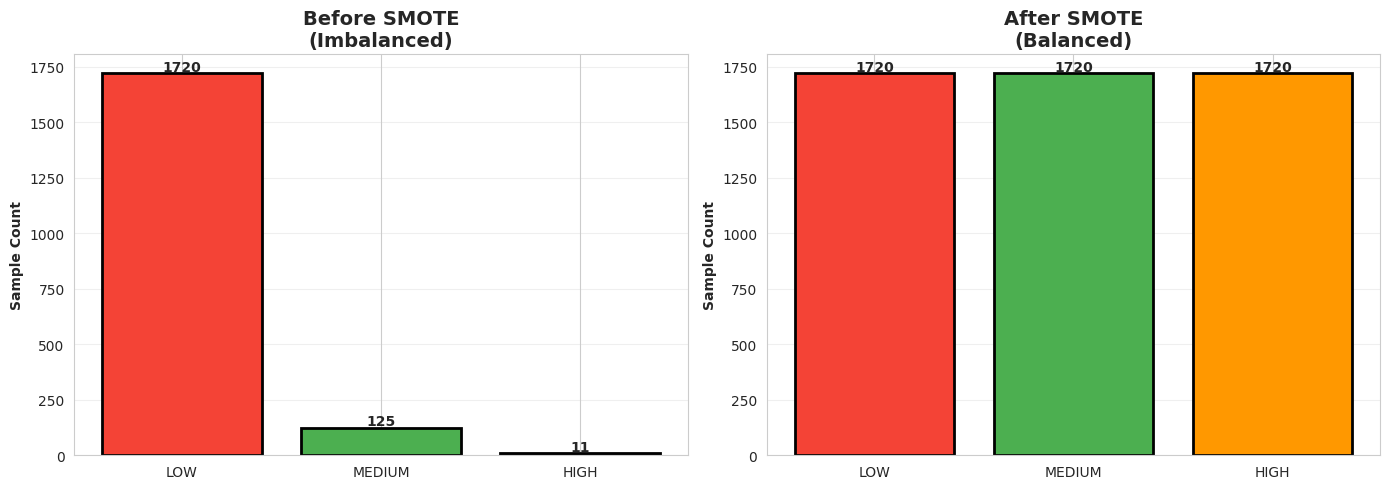

SMOTE balancing visualization saved as '04_smote_balancing.png'


In [28]:
# Visualizing SMOTE Balancing
"""
to see the effect of SMOTE on class distribution.
"""

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
before_counts = pd.Series(le_risk.inverse_transform(y_risk_train)).value_counts()
colors = ['#F44336', '#4CAF50', '#FF9800']
axes[0].bar(range(len(before_counts)), before_counts.values,
            color=colors[:len(before_counts)], edgecolor='black', linewidth=2)
axes[0].set_xticks(range(len(before_counts)))
axes[0].set_xticklabels(before_counts.index)
axes[0].set_title('Before SMOTE\n(Imbalanced)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Sample Count', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, count in enumerate(before_counts.values):
    axes[0].text(i, count + 10, str(count), ha='center', fontweight='bold')

# After SMOTE
after_counts = pd.Series(le_risk.inverse_transform(y_risk_train_balanced)).value_counts()
axes[1].bar(range(len(after_counts)), after_counts.values,
            color=colors[:len(after_counts)], edgecolor='black', linewidth=2)
axes[1].set_xticks(range(len(after_counts)))
axes[1].set_xticklabels(after_counts.index)
axes[1].set_title('After SMOTE\n(Balanced)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Sample Count', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, count in enumerate(after_counts.values):
    axes[1].text(i, count + 10, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/UmutiSafe/outputs/figures/04_smote_balancing.png', dpi=300, bbox_inches='tight')
plt.show()

print("SMOTE balancing visualization saved as '04_smote_balancing.png'")

# SECTION 9: MODEL TRAINING - DISPOSAL CATEGORY CLASSIFICATION
Trained multiple models for disposal category prediction:

1. Random Forest Classifier (baseline)
2. Random Forest with GridSearchCV (hyperparameter tuning)
3. Decision Tree Classifier
4. Regression Tree (for comparison)
5. Gradient Boosting Classifier
6. Multi-Layer Perceptron Neural Network

In [36]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import numpy as np
import pandas as pd


In [37]:
print("\n1. Random Forest Classifier (Baseline)")
print("-" * 80)

category_model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
category_model_rf.fit(X_train, y_cat_train)
y_cat_pred_rf = category_model_rf.predict(X_test)
acc_rf = accuracy_score(y_cat_test, y_cat_pred_rf)

# Add precision, F1 score, and recall
prec_rf = precision_score(y_cat_test, y_cat_pred_rf, average='weighted', zero_division=0)
f1_rf = f1_score(y_cat_test, y_cat_pred_rf, average='weighted', zero_division=0)
rec_rf = recall_score(y_cat_test, y_cat_pred_rf, average='weighted', zero_division=0)

print(f"Accuracy: {acc_rf:.4f} ({acc_rf*100:.2f}%)")
print(f"Precision (weighted): {prec_rf:.4f}")
print(f"Recall (weighted):    {rec_rf:.4f}")
print(f"F1-Score (weighted):  {f1_rf:.4f}")


1. Random Forest Classifier (Baseline)
--------------------------------------------------------------------------------
Accuracy: 0.9785 (97.85%)
Precision (weighted): 0.9764
Recall (weighted):    0.9785
F1-Score (weighted):  0.9774


In [38]:
print("\n2. Random Forest with Hyperparameter Tuning")
print("-" * 80)

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy', n_jobs=1)
grid_search_rf.fit(X_train, y_cat_train)
category_model_tuned = grid_search_rf.best_estimator_
y_cat_pred_tuned = category_model_tuned.predict(X_test)
acc_tuned = accuracy_score(y_cat_test, y_cat_pred_tuned)

# Add precision, F1 score, and recall
prec_tuned = precision_score(y_cat_test, y_cat_pred_tuned, average='weighted', zero_division=0)
f1_tuned = f1_score(y_cat_test, y_cat_pred_tuned, average='weighted', zero_division=0)
rec_tuned = recall_score(y_cat_test, y_cat_pred_tuned, average='weighted', zero_division=0)


print(f"Best Params: {grid_search_rf.best_params_}")
print(f"Accuracy: {acc_tuned:.4f} ({acc_tuned*100:.2f}%)")
print(f"Precision (weighted): {prec_tuned:.4f}")
print(f"Recall (weighted):    {rec_tuned:.4f}")
print(f"F1-Score (weighted):  {f1_tuned:.4f}")


2. Random Forest with Hyperparameter Tuning
--------------------------------------------------------------------------------
Best Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.9849 (98.49%)
Precision (weighted): 0.9828
Recall (weighted):    0.9849
F1-Score (weighted):  0.9837


In [39]:
print("\n3. Decision Tree Classifier")
print("-" * 80)

category_model_dt = DecisionTreeClassifier(random_state=42, max_depth=15, min_samples_split=10, min_samples_leaf=5)
category_model_dt.fit(X_train, y_cat_train)
y_cat_pred_dt = category_model_dt.predict(X_test)
acc_dt = accuracy_score(y_cat_test, y_cat_pred_dt)

# Add precision, F1 score, and recall
prec_dt = precision_score(y_cat_test, y_cat_pred_dt, average='weighted', zero_division=0)
f1_dt = f1_score(y_cat_test, y_cat_pred_dt, average='weighted', zero_division=0)
rec_dt = recall_score(y_cat_test, y_cat_pred_dt, average='weighted', zero_division=0)

print(f"Accuracy: {acc_dt:.4f} ({acc_dt*100:.2f}%)")
print(f"Precision (weighted): {prec_dt:.4f}")
print(f"Recall (weighted):    {rec_dt:.4f}")
print(f"F1-Score (weighted):  {f1_dt:.4f}")


3. Decision Tree Classifier
--------------------------------------------------------------------------------
Accuracy: 0.9677 (96.77%)
Precision (weighted): 0.9663
Recall (weighted):    0.9677
F1-Score (weighted):  0.9669


In [40]:
print("\n4. Regression Tree (Comparison)")
print("-" * 80)

category_model_reg_tree = DecisionTreeRegressor(random_state=42, max_depth=15)
category_model_reg_tree.fit(X_train, y_cat_train)
y_cat_pred_reg_tree = category_model_reg_tree.predict(X_test)
y_cat_pred_reg_tree_rounded = np.round(y_cat_pred_reg_tree).astype(int)
acc_reg_tree = accuracy_score(y_cat_test, y_cat_pred_reg_tree_rounded)

# Add precision, F1 score, and recall for the rounded predictions
prec_reg_tree = precision_score(y_cat_test, y_cat_pred_reg_tree_rounded, average='weighted', zero_division=0)
f1_reg_tree = f1_score(y_cat_test, y_cat_pred_reg_tree_rounded, average='weighted', zero_division=0)
rec_reg_tree = recall_score(y_cat_test, y_cat_pred_reg_tree_rounded, average='weighted', zero_division=0)

print(f"Accuracy (rounded): {acc_reg_tree:.4f} ({acc_reg_tree*100:.2f}%)")
print(f"Precision (weighted, rounded): {prec_reg_tree:.4f}")
print(f"Recall (weighted, rounded):    {rec_reg_tree:.4f}")
print(f"F1-Score (weighted, rounded):  {f1_reg_tree:.4f}")

# Optionally, include regression metrics as well
mse_reg_tree = mean_squared_error(y_cat_test, y_cat_pred_reg_tree)
r2_reg_tree = r2_score(y_cat_test, y_cat_pred_reg_tree)
print(f"Mean Squared Error: {mse_reg_tree:.4f}")
print(f"R-squared Score: {r2_reg_tree:.4f}")


4. Regression Tree (Comparison)
--------------------------------------------------------------------------------
Accuracy (rounded): 0.9742 (97.42%)
Precision (weighted, rounded): 0.9750
Recall (weighted, rounded):    0.9742
F1-Score (weighted, rounded):  0.9743
Mean Squared Error: 0.0498
R-squared Score: 0.8571


In [41]:
print("\n5. Gradient Boosting Classifier")
print("-" * 80)

category_model_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
category_model_gb.fit(X_train, y_cat_train)
y_cat_pred_gb = category_model_gb.predict(X_test)
acc_gb = accuracy_score(y_cat_test, y_cat_pred_gb)

# precision, F1 score, and recall
prec_gb = precision_score(y_cat_test, y_cat_pred_gb, average='weighted', zero_division=0)
f1_gb = f1_score(y_cat_test, y_cat_pred_gb, average='weighted', zero_division=0)
rec_gb = recall_score(y_cat_test, y_cat_pred_gb, average='weighted', zero_division=0)


print(f"Accuracy: {acc_gb:.4f} ({acc_gb*100:.2f}%)")
print(f"Precision (weighted): {prec_gb:.4f}")
print(f"Recall (weighted):    {rec_gb:.4f}")
print(f"F1-Score (weighted):  {f1_gb:.4f}")


5. Gradient Boosting Classifier
--------------------------------------------------------------------------------
Accuracy: 0.9806 (98.06%)
Precision (weighted): 0.9826
Recall (weighted):    0.9806
F1-Score (weighted):  0.9815


In [42]:
#  Neural Network
"""
Multi-Layer Perceptron with GridSearchCV for optimal architecture.
"""

print(". Multi-Layer Perceptron Neural Network ")
print("-" * 80)

param_grid_mlp = {
    'hidden_layer_sizes': [(64,), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

mlp_category = MLPClassifier(
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

grid_search_mlp_cat = GridSearchCV(
    mlp_category,
    param_grid_mlp,
    cv=3,
    scoring='accuracy',
    n_jobs=1,
    verbose=1
)
grid_search_mlp_cat.fit(X_train, y_cat_train)
category_model_mlp = grid_search_mlp_cat.best_estimator_
y_cat_pred_mlp = category_model_mlp.predict(X_test)
acc_mlp = accuracy_score(y_cat_test, y_cat_pred_mlp)

print(f"\nBest Parameters: {grid_search_mlp_cat.best_params_}")
print(f"Best CV Score: {grid_search_mlp_cat.best_score_:.4f}")
print(f"Test Accuracy: {acc_mlp:.4f} ({acc_mlp*100:.2f}%)")
print(f"Training iterations: {category_model_mlp.n_iter_}")

. Multi-Layer Perceptron Neural Network 
--------------------------------------------------------------------------------
Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.01}
Best CV Score: 0.9720
Test Accuracy: 0.9742 (97.42%)
Training iterations: 40


####**Category Model Comparison and Selection**

In [43]:
print("\nCATEGORY MODEL COMPARISON")
print("="*80)

category_models = {
    'Random Forest (Baseline)': acc_rf,
    'Random Forest (Tuned)': acc_tuned,
    'Decision Tree': acc_dt,
    'Regression Tree': acc_reg_tree,
    'Gradient Boosting': acc_gb,
    'Neural Network': acc_mlp
}

comparison_df = pd.DataFrame(list(category_models.items()), columns=['Model', 'Accuracy']).sort_values('Accuracy', ascending=False)
display(comparison_df)

best_model_name = comparison_df.iloc[0]['Model']
best_acc = comparison_df.iloc[0]['Accuracy']
print(f"\n🏆 Best Model: {best_model_name} with Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")



CATEGORY MODEL COMPARISON


,Model,Accuracy
1,Random Forest (Tuned),0.984946
4,Gradient Boosting,0.980645
0,Random Forest (Baseline),0.978495
3,Regression Tree,0.974194
5,Neural Network,0.974194
2,Decision Tree,0.967742



🏆 Best Model: Random Forest (Tuned) with Accuracy: 0.9849 (98.49%)


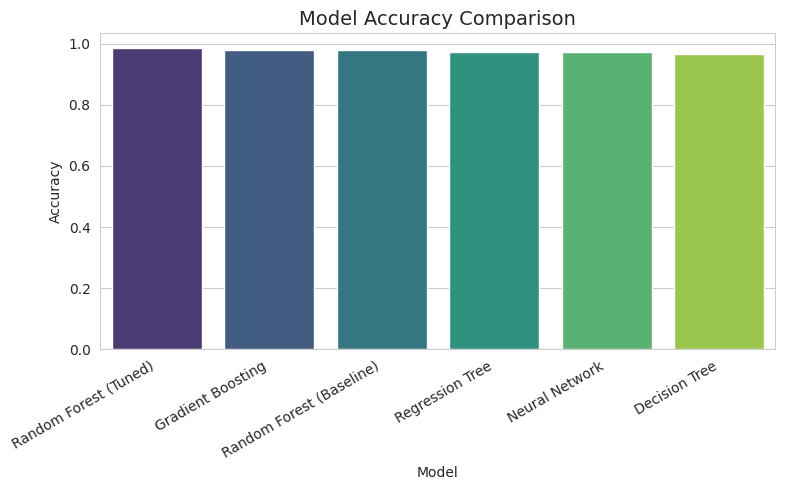

 Best category model saved successfully!


In [44]:
import joblib # Import the joblib library

plt.figure(figsize=(8,5))
sns.barplot(data=comparison_df, x='Model', y='Accuracy', palette='viridis')
plt.title("Model Accuracy Comparison", fontsize=14)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()
# Save best model automatically
best_category_model = {
    'Random Forest (Baseline)': category_model_rf,
    'Random Forest (Tuned)': category_model_tuned,
    'Decision Tree': category_model_dt,
    'Regression Tree': category_model_reg_tree,
    'Gradient Boosting': category_model_gb,
    'Neural Network': mlp_category
}[best_model_name]

joblib.dump(best_category_model, '/content/drive/MyDrive/UmutiSafe/models/best_category_model.pkl')
print(" Best category model saved successfully!") # Added print

# SECTION 10: MODEL TRAINING - RISK LEVEL CLASSIFICATION
Training models for risk level classification:
- Using balanced data (SMOTE)
- Apply class weights
- Train multiple models
- Select best model for HIGH-risk detection

In [45]:
#  Random Forest with Class Weights
"""
 Random Forest with class weights for risk classification.
"""

print("RISK LEVEL CLASSIFICATION - MODEL TRAINING")
print("="*80)

print("\n1. Random Forest with Class Weights")
print("-" * 80)

risk_model_weighted = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weight_dict_risk,
    random_state=42,
    n_jobs=-1
)
risk_model_weighted.fit(X_train, y_risk_train)
y_risk_pred_weighted = risk_model_weighted.predict(X_test)
acc_weighted = accuracy_score(y_risk_test, y_risk_pred_weighted)
f1_weighted = f1_score(y_risk_test, y_risk_pred_weighted, average='macro')

print(f"Accuracy: {acc_weighted:.4f} ({acc_weighted*100:.2f}%)")
print(f"F1-Score (macro): {f1_weighted:.4f}")

RISK LEVEL CLASSIFICATION - MODEL TRAINING

1. Random Forest with Class Weights
--------------------------------------------------------------------------------
Accuracy: 0.9269 (92.69%)
F1-Score (macro): 0.5941


In [46]:
# Random Forest with SMOTE
"""
Random Forest on SMOTE-balanced data.
"""

print("\n2. Random Forest with SMOTE")
print("-" * 80)

risk_model_smote = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
risk_model_smote.fit(X_train_balanced, y_risk_train_balanced)
y_risk_pred_smote = risk_model_smote.predict(X_test)
acc_smote = accuracy_score(y_risk_test, y_risk_pred_smote)
f1_smote = f1_score(y_risk_test, y_risk_pred_smote, average='macro')

print(f"Accuracy: {acc_smote:.4f} ({acc_smote*100:.2f}%)")
print(f"F1-Score (macro): {f1_smote:.4f}")



2. Random Forest with SMOTE
--------------------------------------------------------------------------------
Accuracy: 0.9140 (91.40%)
F1-Score (macro): 0.6188


In [47]:
"""
Gradient Boosting on balanced data.
"""

print("\n3. Gradient Boosting with SMOTE")
print("-" * 80)

risk_model_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
risk_model_gb.fit(X_train_balanced, y_risk_train_balanced)
y_risk_pred_gb = risk_model_gb.predict(X_test)
acc_gb_risk = accuracy_score(y_risk_test, y_risk_pred_gb)
f1_gb_risk = f1_score(y_risk_test, y_risk_pred_gb, average='macro')

print(f"Accuracy: {acc_gb_risk:.4f} ({acc_gb_risk*100:.2f}%)")
print(f"F1-Score (macro): {f1_gb_risk:.4f}")


3. Gradient Boosting with SMOTE
--------------------------------------------------------------------------------
Accuracy: 0.8946 (89.46%)
F1-Score (macro): 0.5576


In [48]:
# Neural Network
print("\n4. Neural Network with  (SMOTE)")
print("-" * 80)

param_grid_mlp_risk = {
    'hidden_layer_sizes': [(64,), (128, 64), (64, 32)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

grid_search_mlp_risk = GridSearchCV(
    MLPClassifier(max_iter=500, random_state=42, early_stopping=True),
    param_grid_mlp_risk,
    cv=3,
    scoring='f1_macro',
    n_jobs=1,
    verbose=1
)
grid_search_mlp_risk.fit(X_train_balanced, y_risk_train_balanced)
risk_model_mlp = grid_search_mlp_risk.best_estimator_
y_risk_pred_mlp = risk_model_mlp.predict(X_test)
acc_mlp_risk = accuracy_score(y_risk_test, y_risk_pred_mlp)
f1_mlp_risk = f1_score(y_risk_test, y_risk_pred_mlp, average='macro')

print(f"\nBest Parameters: {grid_search_mlp_risk.best_params_}")
print(f"Best CV F1-Score: {grid_search_mlp_risk.best_score_:.4f}")
print(f"Test Accuracy: {acc_mlp_risk:.4f} ({acc_mlp_risk*100:.2f}%)")
print(f"Test F1-Score (macro): {f1_mlp_risk:.4f}")


4. Neural Network with  (SMOTE)
--------------------------------------------------------------------------------
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (64,), 'learning_rate_init': 0.01}
Best CV F1-Score: 0.9536
Test Accuracy: 0.8645 (86.45%)
Test F1-Score (macro): 0.4961


In [49]:
# Risk Model Comparison and Selection
"""
Compare risk models prioritizing HIGH-risk recall.
"""

print("RISK MODEL COMPARISON")
print("="*80)

# Calculate HIGH-risk recall for each model
report_weighted = classification_report(y_risk_test, y_risk_pred_weighted,
                                       target_names=le_risk.classes_,
                                       output_dict=True, zero_division=0)
report_smote = classification_report(y_risk_test, y_risk_pred_smote,
                                     target_names=le_risk.classes_,
                                     output_dict=True, zero_division=0)
report_gb = classification_report(y_risk_test, y_risk_pred_gb,
                                  target_names=le_risk.classes_,
                                  output_dict=True, zero_division=0)
report_mlp = classification_report(y_risk_test, y_risk_pred_mlp,
                                   target_names=le_risk.classes_,
                                   output_dict=True, zero_division=0)

high_recall_weighted = report_weighted.get('HIGH', {}).get('recall', 0)
high_recall_smote = report_smote.get('HIGH', {}).get('recall', 0)
high_recall_gb = report_gb.get('HIGH', {}).get('recall', 0)
high_recall_mlp = report_mlp.get('HIGH', {}).get('recall', 0)

risk_comparison = pd.DataFrame({
    'Model': ['RF + Weights', 'RF + SMOTE', 'GB + SMOTE', 'NN + SMOTE'],
    'Accuracy': [acc_weighted, acc_smote, acc_gb_risk, acc_mlp_risk],
    'F1-Score': [f1_weighted, f1_smote, f1_gb_risk, f1_mlp_risk],
    'HIGH_Recall': [high_recall_weighted, high_recall_smote, high_recall_gb, high_recall_mlp]
}).sort_values('HIGH_Recall', ascending=False) # Complete the DataFrame creation and sort


print("\nModel Performance Ranking (by HIGH-risk recall):")
print(risk_comparison.to_string(index=False))

# Select best model based on HIGH-risk recall
best_idx = risk_comparison['HIGH_Recall'].idxmax()
risk_models_list = [risk_model_weighted, risk_model_smote, risk_model_gb, risk_model_mlp]
best_risk_preds = [y_risk_pred_weighted, y_risk_pred_smote, y_risk_pred_gb, y_risk_pred_mlp]

best_risk_model = risk_models_list[best_idx]
best_risk_pred = best_risk_preds[best_idx]
best_risk_name = risk_comparison.loc[best_idx, 'Model']

print(f"\nBest Model Selected: {best_risk_name}")
print(f"HIGH-risk Recall: {risk_comparison.loc[best_idx, 'HIGH_Recall']:.4f}")
print(f"Overall F1-Score: {risk_comparison.loc[best_idx, 'F1-Score']:.4f}")

RISK MODEL COMPARISON

Model Performance Ranking (by HIGH-risk recall):
       Model  Accuracy  F1-Score  HIGH_Recall
RF + Weights  0.926882  0.594075          0.5
  RF + SMOTE  0.913978  0.618766          0.5
  GB + SMOTE  0.894624  0.557620          0.5
  NN + SMOTE  0.864516  0.496055          0.5

Best Model Selected: RF + Weights
HIGH-risk Recall: 0.5000
Overall F1-Score: 0.5941


In [83]:
# Create and Save Model Metadata

print("\nCREATING AND SAVING MODEL METADATA")
print("="*80)

# Determine the name of the best category model from the comparison_df
# Assuming comparison_df is available from cell cHGgSIIjIUGL
if 'comparison_df' in locals():
    best_category_model_name = comparison_df.iloc[0]['Model']
    # Map the display name to the actual variable name or file name prefix
    model_name_map = {
        'Random Forest (Baseline)': 'random_forest_baseline',
        'Random Forest (Tuned)': 'random_forest_tuned',
        'Decision Tree': 'decision_tree',
        'Regression Tree': 'regression_tree',
        'Gradient Boosting': 'gradient_boosting',
        'Neural Network': 'neural_network'
    }
    best_model_file_prefix = model_name_map.get(best_category_model_name, 'best_category_model') # Use the saved filename

else:
    print("Warning: comparison_df not found. Cannot determine best category model name automatically.")
    best_model_file_prefix = 'best_category_model' # Default to the saved filename

# Assuming feature_names_list is available from cell d0BfJmASfHwk
if 'feature_names_list' in locals():
     feature_columns = feature_names_list
else:
    print("Warning: feature_names_list not found. Cannot determine feature columns automatically.")
    # Attempt to reconstruct feature names based on previous steps
    # Assuming tfidf was fitted and text_features_df columns were used
    tfidf_feature_names = tfidf.get_feature_names_out().tolist() if 'tfidf' in locals() and hasattr(tfidf, 'get_feature_names_out') else []
    text_feature_names = ['word_count', 'char_count', 'special_chars']
    feature_columns = tfidf_feature_names + text_feature_names


metadata = {
    'best_category_model': best_model_file_prefix, # Use the file name prefix
    'feature_columns': feature_columns,
    'description': 'Metadata for UmutiSafe medicine disposal prediction models',
    'created_at': datetime.now().isoformat()
}

models_folder_path = '/content/drive/MyDrive/UmutiSafe/models'
metadata_save_path = f"{models_folder_path}/model_metadata.json"

try:
    with open(metadata_save_path, 'w') as f:
        json.dump(metadata, f, indent=4)
    print(f"Model metadata saved successfully to: {metadata_save_path}")
except Exception as e:
    print(f"Error saving model metadata: {e}")


CREATING AND SAVING MODEL METADATA
Model metadata saved successfully to: /content/drive/MyDrive/UmutiSafe/models/model_metadata.json


RISK MODEL COMPARISON VISUALIZATION


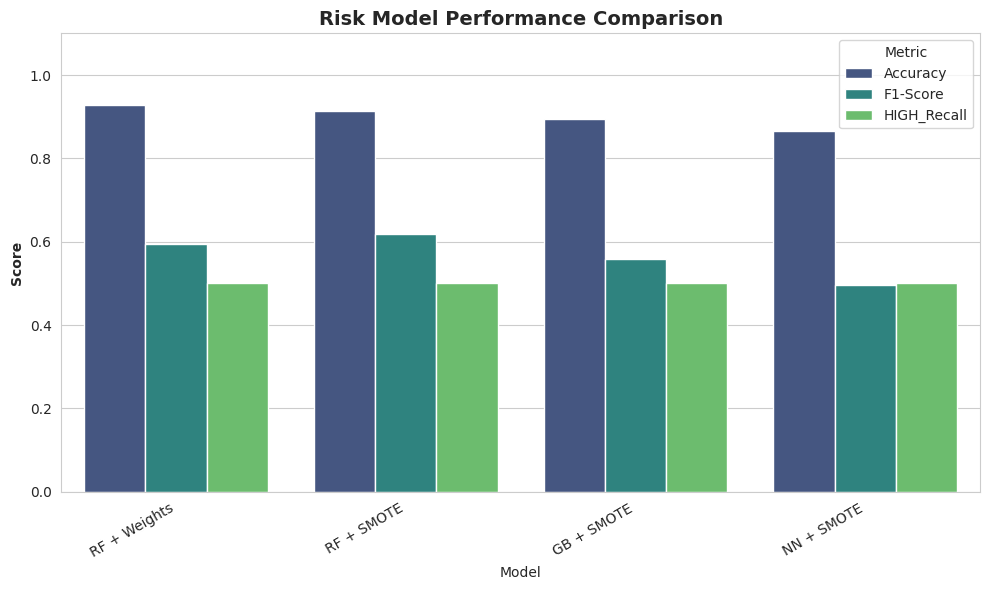


Risk model comparison visualization saved as '09_risk_model_comparison.png'
 Best risk model ('RF + Weights') saved successfully to: /content/drive/MyDrive/UmutiSafe/models/best_risk_model.pkl


In [50]:
import joblib # Import the joblib library

print("RISK MODEL COMPARISON VISUALIZATION")
print("="*80)

# Assuming risk_comparison DataFrame is available from the previous cell
# Assuming best_risk_model and best_risk_name are available from the previous cell

plt.figure(figsize=(10, 6))
# Using the risk_comparison DataFrame which contains 'Model', 'Accuracy', 'F1-Score', 'HIGH_Recall'
# Plotting multiple metrics for comparison
risk_comparison_melted = risk_comparison.melt(id_vars='Model', var_name='Metric', value_name='Score',
                                             value_vars=['Accuracy', 'F1-Score', 'HIGH_Recall'])

sns.barplot(data=risk_comparison_melted, x='Model', y='Score', hue='Metric', palette='viridis')
plt.title("Risk Model Performance Comparison", fontsize=14, fontweight='bold')
plt.ylabel("Score", fontweight='bold')
plt.xticks(rotation=30, ha='right')
plt.ylim(0, 1.1)
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/UmutiSafe/outputs/figures/09_risk_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nRisk model comparison visualization saved as '09_risk_model_comparison.png'")

# Save best risk model
models_folder_path = '/content/drive/MyDrive/UmutiSafe/models'
save_path_risk = f"{models_folder_path}/best_risk_model.pkl"

try:
    joblib.dump(best_risk_model, save_path_risk)
    print(f" Best risk model ('{best_risk_name}') saved successfully to: {save_path_risk}") # Added print
except Exception as e:
    print(f"Error saving best risk model: {e}")

# SECTION 11: MODEL EVALUATION AND PERFORMANCE METRICS
Comprehensive models evaluation:
- Classification reports
- Confusion matrices
- Performance metrics (accuracy, precision, recall, F1-score)
- Cross-validation results

DISPOSAL CATEGORY MODEL EVALUATION
Model: Random Forest (Tuned)

Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       311
           2       0.97      1.00      0.98       130
           3       0.95      0.87      0.91        23
           4       0.00      0.00      0.00         1

    accuracy                           0.98       465
   macro avg       0.73      0.71      0.72       465
weighted avg       0.98      0.98      0.98       465


Overall Metrics:
--------------------------------------------------------------------------------
Accuracy:  0.9849 (98.49%)
Precision (weighted): 0.9828
Recall (weighted):    0.9849
F1-Score (weighted):  0.9837


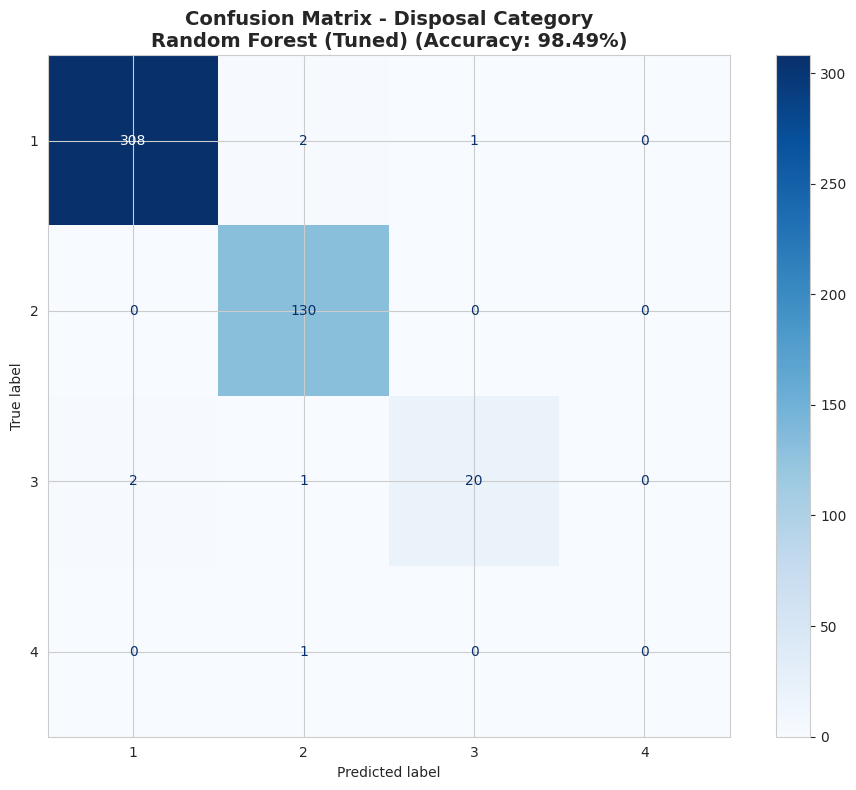


Confusion matrix saved as '05_category_confusion_matrix.png'


In [51]:
# Category Model Evaluation

print("DISPOSAL CATEGORY MODEL EVALUATION")
# Retrieve the name of the best category model from the comparison_df
best_category_model_name = comparison_df.iloc[0]['Model']
print(f"Model: {best_category_model_name}")
print("="*80)

# Determine the predictions of the best category model
if best_category_model_name == 'Random Forest (Baseline)':
    best_cat_pred = y_cat_pred_rf
elif best_category_model_name == 'Random Forest (Tuned)':
    best_cat_pred = y_cat_pred_tuned
elif best_category_model_name == 'Decision Tree':
    best_cat_pred = y_cat_pred_dt
elif best_category_model_name == 'Regression Tree':
     # Use the rounded predictions for evaluation metrics
    best_cat_pred = y_cat_pred_reg_tree_rounded
elif best_category_model_name == 'Gradient Boosting':
    best_cat_pred = y_cat_pred_gb
elif best_category_model_name == 'Neural Network':
    best_cat_pred = y_cat_pred_mlp
else:
    print("Warning: Could not determine predictions for the best category model.")
    best_cat_pred = None # Handle case where best_cat_pred is not set

if best_cat_pred is not None:
    # Classification Report
    print("\nClassification Report:")
    print("-" * 80)
    # Ensure target names match the encoded labels
    cat_report = classification_report(y_cat_test, best_cat_pred,
                                       target_names=[str(le_category.inverse_transform([i])[0]) for i in np.unique(y_cat_test)],
                                       zero_division=0)
    print(cat_report)

    # Calculate detailed metrics
    acc_cat = accuracy_score(y_cat_test, best_cat_pred)
    prec_cat = precision_score(y_cat_test, best_cat_pred, average='weighted', zero_division=0)
    rec_cat = recall_score(y_cat_test, best_cat_pred, average='weighted', zero_division=0)
    f1_cat = f1_score(y_cat_test, best_cat_pred, average='weighted', zero_division=0)

    print("\nOverall Metrics:")
    print("-" * 80)
    print(f"Accuracy:  {acc_cat:.4f} ({acc_cat*100:.2f}%)")
    print(f"Precision (weighted): {prec_cat:.4f}")
    print(f"Recall (weighted):    {rec_cat:.4f}")
    print(f"F1-Score (weighted):  {f1_cat:.4f}")

    # Confusion Matrix Visualization
    fig, ax = plt.subplots(figsize=(10, 8))
    cm_cat = confusion_matrix(y_cat_test, best_cat_pred)
    # Ensure display labels match the original category names
    display_labels_cat = [str(le_category.inverse_transform([i])[0]) for i in np.unique(y_cat_test)]
    disp_cat = ConfusionMatrixDisplay(confusion_matrix=cm_cat,
                                       display_labels=display_labels_cat)
    disp_cat.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Confusion Matrix - Disposal Category\n{best_category_model_name} (Accuracy: {acc_cat:.2%})',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/UmutiSafe/outputs/figures/05_category_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nConfusion matrix saved as '05_category_confusion_matrix.png'")
else:
    print("\nCategory model evaluation skipped due to undefined predictions.")

RISK LEVEL MODEL EVALUATION
Model: RF + Weights

Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

        HIGH       1.00      0.50      0.67         2
         LOW       0.93      1.00      0.96       428
      MEDIUM       0.75      0.09      0.15        35

    accuracy                           0.93       465
   macro avg       0.89      0.53      0.59       465
weighted avg       0.92      0.93      0.90       465


Overall Metrics:
--------------------------------------------------------------------------------
Accuracy:  0.9269 (92.69%)
Precision (weighted): 0.9152
Recall (weighted):    0.9269
F1-Score (weighted):  0.8996

Per-Class Metrics:
--------------------------------------------------------------------------------
HIGH:
  Precision: 1.0000
  Recall:    0.5000
  F1-Score:  0.6667
LOW:
  Precision: 0.9283
  Recall:    0.9977
  F1-Score:  0.9617
MEDIUM:
  Precision: 

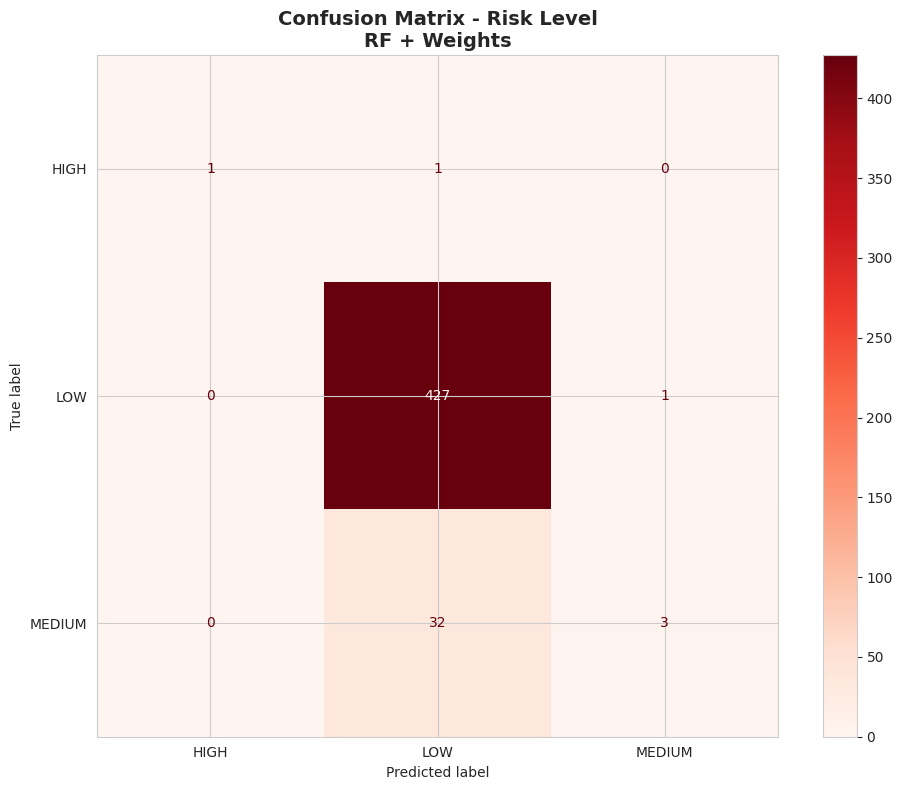


Confusion matrix saved as '06_risk_confusion_matrix.png'


In [52]:
# Risk Model Evaluation

print("RISK LEVEL MODEL EVALUATION")
print("="*80)
# Assuming best_risk_model and best_risk_name are available from previous cells
print(f"Model: {best_risk_name}")
print("="*80)

# Classification Report
print("\nClassification Report:")
print("-" * 80)
# Ensure best_risk_pred is available
# Assuming best_risk_pred was defined when selecting the best model in cell Z5MdhZP_eDbf
risk_report = classification_report(y_risk_test, best_risk_pred,
                                    target_names=le_risk.classes_,
                                    zero_division=0)
print(risk_report)

# Calculate detailed metrics
acc_risk = accuracy_score(y_risk_test, best_risk_pred)
prec_risk = precision_score(y_risk_test, best_risk_pred, average='weighted', zero_division=0)
rec_risk = recall_score(y_risk_test, best_risk_pred, average='weighted', zero_division=0)
f1_risk = f1_score(y_risk_test, best_risk_pred, average='weighted', zero_division=0)

print("\nOverall Metrics:")
print("-" * 80)
print(f"Accuracy:  {acc_risk:.4f} ({acc_risk*100:.2f}%)")
print(f"Precision (weighted): {prec_risk:.4f}")
print(f"Recall (weighted):    {rec_risk:.4f}")
print(f"F1-Score (weighted):  {f1_risk:.4f}")

# Per-class metrics
print("\nPer-Class Metrics:")
print("-" * 80)
# Use the classification report of the best risk model to get per-class metrics
# 'report_weighted' is the report for the best model ('RF + Weights')
report_dict_risk = classification_report(y_risk_test, best_risk_pred,
                                        target_names=le_risk.classes_,
                                        output_dict=True, zero_division=0)

for cls_name in le_risk.classes_:
    if cls_name in report_dict_risk:
        cls_metrics = report_dict_risk[cls_name]
        print(f"{cls_name}:")
        print(f"  Precision: {cls_metrics['precision']:.4f}")
        print(f"  Recall:    {cls_metrics['recall']:.4f}")
        print(f"  F1-Score:  {cls_metrics['f1-score']:.4f}")


# Confusion Matrix Visualization
fig, ax = plt.subplots(figsize=(10, 8))
cm_risk = confusion_matrix(y_risk_test, best_risk_pred)
disp_risk = ConfusionMatrixDisplay(confusion_matrix=cm_risk,
                                    display_labels=le_risk.classes_)
disp_risk.plot(ax=ax, cmap='Reds', values_format='d')
ax.set_title(f'Confusion Matrix - Risk Level\n{best_risk_name}',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/UmutiSafe/outputs/figures/06_risk_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved as '06_risk_confusion_matrix.png'")

In [54]:
# Cross-Validation
"""
Performed k-fold cross-validation for robust performance estimation.
"""

print("CROSS-VALIDATION (5-FOLD)")
print("="*80)

# Category model cross-validation
print("\n1. Disposal Category Classification:")
print("-" * 80)
cv_scores_cat = cross_val_score(best_category_model, X, y_category_encoded,
                                cv=5, scoring='accuracy', n_jobs=1) # Changed n_jobs to 1
print(f"Fold Accuracies: {[f'{s:.4f}' for s in cv_scores_cat]}")
print(f"Mean Accuracy: {cv_scores_cat.mean():.4f} ± {cv_scores_cat.std():.4f}")
print(f"95% Confidence Interval: [{cv_scores_cat.mean() - 1.96*cv_scores_cat.std():.4f}, "
      f"{cv_scores_cat.mean() + 1.96*cv_scores_cat.std():.4f}]")

# Risk model cross-validation (on balanced data)
print("\n2. Risk Level Classification:")
print("-" * 80)
cv_scores_risk = cross_val_score(best_risk_model, X_train_balanced, y_risk_train_balanced,
                                 cv=5, scoring='f1_macro', n_jobs=1) # Changed n_jobs to 1
print(f"Fold F1-Scores: {[f'{s:.4f}' for s in cv_scores_risk]}")
print(f"Mean F1-Score: {cv_scores_risk.mean():.4f} ± {cv_scores_risk.std():.4f}")
print(f"95% Confidence Interval: [{cv_scores_risk.mean() - 1.96*cv_scores_risk.std():.4f}, "
      f"{cv_scores_risk.mean() + 1.96*cv_scores_risk.std():.4f}]")

CROSS-VALIDATION (5-FOLD)

1. Disposal Category Classification:
--------------------------------------------------------------------------------
Fold Accuracies: ['0.9613', '0.9763', '0.9828', '0.9806', '0.9806']
Mean Accuracy: 0.9763 ± 0.0078
95% Confidence Interval: [0.9610, 0.9916]

2. Risk Level Classification:
--------------------------------------------------------------------------------
Fold F1-Scores: ['0.9329', '0.9922', '0.9874', '0.9922', '0.9942']
Mean F1-Score: 0.9798 ± 0.0236
95% Confidence Interval: [0.9336, 1.0260]


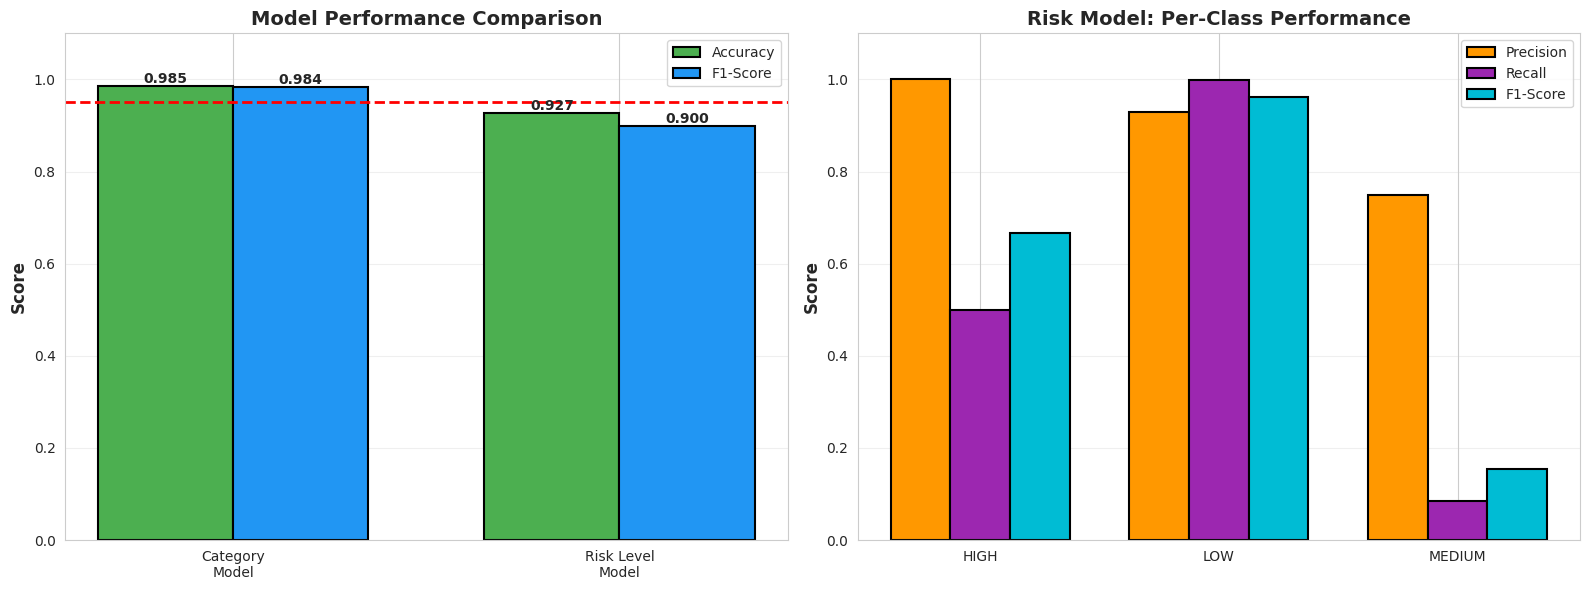

Performance comparison visualization saved as '07_model_performance_comparison.png'


In [53]:
# C Performance Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Model Performance Comparison
models = ['Category\nModel', 'Risk Level\nModel']
accuracies = [acc_cat, acc_risk]
f1_scores = [f1_cat, f1_risk]

x = np.arange(len(models))
width = 0.35

bars1 = axes[0].bar(x - width/2, accuracies, width, label='Accuracy',
                     color='#4CAF50', edgecolor='black', linewidth=1.5)
bars2 = axes[0].bar(x + width/2, f1_scores, width, label='F1-Score',
                     color='#2196F3', edgecolor='black', linewidth=1.5)

axes[0].set_ylabel('Score', fontweight='bold', fontsize=12)
axes[0].set_title('Model Performance Comparison', fontweight='bold', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].set_ylim([0, 1.1])
axes[0].axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% Target')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Per-Class Performance (Risk Model)
risk_classes = le_risk.classes_
risk_report_dict = classification_report(y_risk_test, best_risk_pred,
                                         target_names=risk_classes,
                                         output_dict=True, zero_division=0)

precisions = [risk_report_dict[cls]['precision'] for cls in risk_classes]
recalls = [risk_report_dict[cls]['recall'] for cls in risk_classes]
f1s = [risk_report_dict[cls]['f1-score'] for cls in risk_classes]

x2 = np.arange(len(risk_classes))
width2 = 0.25

axes[1].bar(x2 - width2, precisions, width2, label='Precision',
            color='#FF9800', edgecolor='black', linewidth=1.5)
axes[1].bar(x2, recalls, width2, label='Recall',
            color='#9C27B0', edgecolor='black', linewidth=1.5)
axes[1].bar(x2 + width2, f1s, width2, label='F1-Score',
            color='#00BCD4', edgecolor='black', linewidth=1.5)

axes[1].set_ylabel('Score', fontweight='bold', fontsize=12)
axes[1].set_title('Risk Model: Per-Class Performance', fontweight='bold', fontsize=14)
axes[1].set_xticks(x2)
axes[1].set_xticklabels(risk_classes)
axes[1].legend()
axes[1].set_ylim([0, 1.1])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/UmutiSafe/outputs/figures/07_model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Performance comparison visualization saved as '07_model_performance_comparison.png'")

# SECTION 12: FEATURE IMPORTANCE ANALYSIS
 Analyzed and visualized feature importance
- Extract feature importance from tree-based models
- Identify most influential features
- Visualize top features

FEATURE IMPORTANCE ANALYSIS

Category Model Feature Importance:
--------------------------------------------------------------------------------

Top 20 Most Important Features:
     Feature  Importance
     tablets    0.152650
    solution    0.089170
         pvc    0.044626
       cream    0.041265
       glass    0.039001
     blister    0.038690
      powder    0.038474
        tube    0.037462
      bottle    0.032167
solution for    0.028716
         alu    0.027706
  powder for    0.026635
       amber    0.025121
   injection    0.025045
       syrup    0.022820
          ml    0.021517
  suspension    0.019748
    capsules    0.019704
         for    0.015691
        film    0.013987

Feature importance data saved to: /content/drive/MyDrive/UmutiSafe/outputs/results/feature_importance.csv


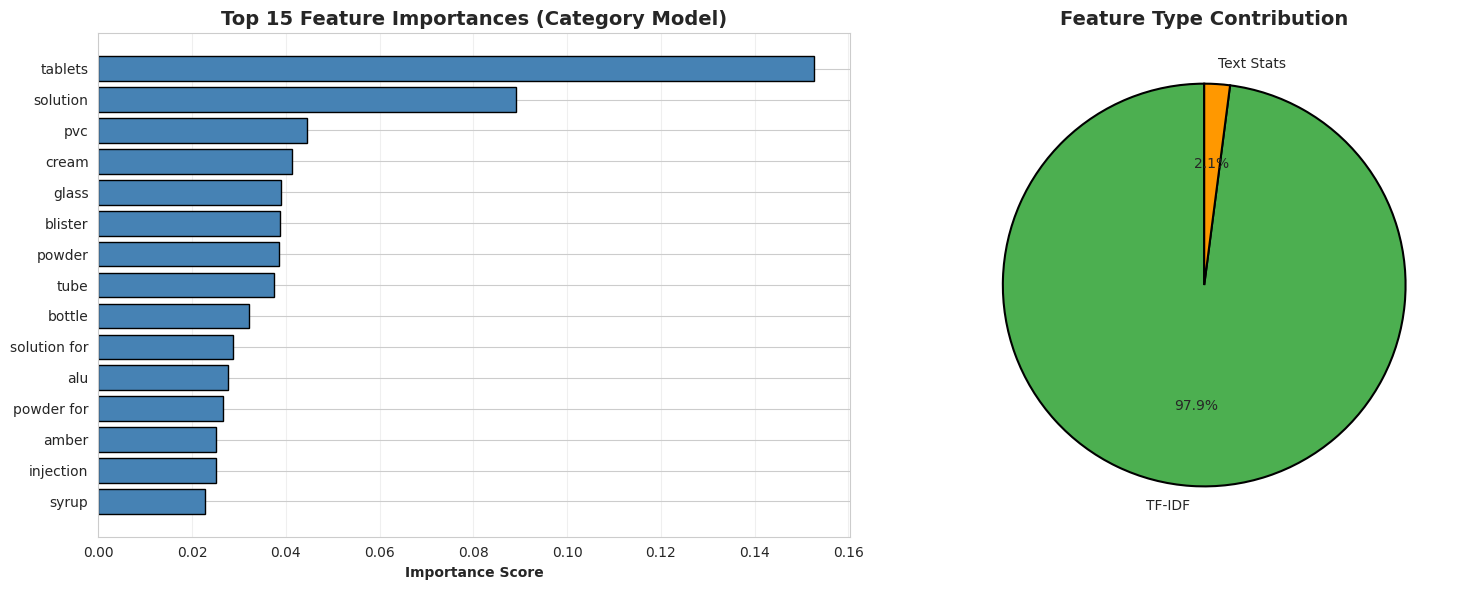


Feature importance visualization saved as '08_feature_importance.png'


In [55]:
# Feature Importance Analysis

print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Check if best category model has feature importance
if hasattr(best_category_model, 'feature_importances_'):
    print("\nCategory Model Feature Importance:")
    print("-" * 80)

    # Create feature names (combination of TF-IDF, Word2Vec, and text features)
    feature_names_list = (list(tfidf.get_feature_names_out()) +
                         # [f'w2v_{i}' for i in range(50)] + # Removed due to Word2Vec skip
                         ['word_count', 'char_count', 'special_chars'])

    # Get feature importance
    importances = best_category_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Create a DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'Feature': [feature_names_list[i] for i in indices],
        'Importance': importances[indices]
    })

    # Top 20 features
    print("\nTop 20 Most Important Features:")
    print(feature_importance_df.head(20).to_string(index=False))

    # Save feature importance DataFrame to Google Drive
    output_path = '/content/drive/MyDrive/UmutiSafe/outputs/results/feature_importance.csv'
    try:
        feature_importance_df.to_csv(output_path, index=False)
        print(f"\nFeature importance data saved to: {output_path}")
    except Exception as e:
        print(f"\nError saving feature importance data: {e}")


    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Top 15 features
    top_n = 15
    top_indices = indices[:top_n]
    top_features = [feature_names_list[i] for i in top_indices]
    top_importances = importances[top_indices]

    axes[0].barh(range(len(top_features)), top_importances, color='steelblue', edgecolor='black')
    axes[0].set_yticks(range(len(top_features)))
    axes[0].set_yticklabels(top_features)
    axes[0].set_xlabel('Importance Score', fontweight='bold')
    axes[0].set_title('Top 15 Feature Importances (Category Model)', fontweight='bold', fontsize=14)
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)

    # Plot 2: Feature type distribution
    tfidf_importance = np.sum(importances[:len(tfidf.get_feature_names_out())])
    # w2v_importance = np.sum(importances[len(tfidf.get_feature_names_out()):len(tfidf.get_feature_names_out())+50]) # Removed
    text_importance = np.sum(importances[-3:])

    feature_types = ['TF-IDF', 'Text Stats'] # Removed Word2Vec from labels
    type_importances = [tfidf_importance, text_importance] # Removed Word2Vec from values
    colors_types = ['#4CAF50', '#FF9800'] # Adjusted colors

    axes[1].pie(type_importances, labels=feature_types, autopct='%1.1f%%',
                colors=colors_types, startangle=90,
                wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
    axes[1].set_title('Feature Type Contribution', fontweight='bold', fontsize=14)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/UmutiSafe/outputs/figures/08_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nFeature importance visualization saved as '08_feature_importance.png'")
else:
    print("\nSelected model does not provide feature importance")

# SECTION 13: DISPOSAL GUIDELINES DATABASE
Comprehensive disposal guidelines for each category:
- Step-by-step procedures
- Safety precautions
- Prohibitions
- Special handling instructions

In [56]:
%%writefile disposal_guidelines_db.py
# Disposal Guidelines Database
"""
Defined comprehensive disposal guidelines for all categories.
Based on WHO guidelines and Rwanda FDA regulations.
"""

import json

disposal_guidelines = {
    1: {  # Solids
        'category_name': 'Solids (Tablets, Capsules, Powders)',
        'icon': '',
        'quick_summary': {
            'safe_method': 'Encapsulate and dispose in secure landfill or incinerate.',
            'time_required': '30-60 minutes (per batch)',
            'can_diy': True
        },
        'steps': [
            {
                'step': 1,
                'title': 'Preparation and Sorting',
                'actions': [
                    'Wear appropriate Personal Protective Equipment (PPE): gloves, mask, and protective gown',
                    'Sort expired or unused tablets separately from regular waste',
                    'Check expiry dates and verify medicine names',
                    'Document the quantity and type of medicine being disposed',
                    'Keep a disposal log with date, medicine name, quantity, and reason for disposal'
                ]
            },
            {
                'step': 2,
                'title': 'Packaging Removal',
                'actions': [
                    'Remove medicines from outer cardboard or paper packaging',
                    'Keep medicines in their original blister packs or inner packaging',
                    'Do NOT remove individual tablets from blister packs',
                    'Separate packaging materials for recycling if possible',
                    'Ensure labels remain legible for identification'
                ]
            },
            {
                'step': 3,
                'title': 'Container Preparation',
                'actions': [
                    'Use clean plastic drums (HDPE) or steel drums with secure lids',
                    'Label drums clearly: "PHARMACEUTICAL WASTE - SOLIDS"',
                    'Add date of collection on the label',
                    'If handling large quantities of one drug, mix with other medicines',
                    'Fill containers to maximum 75% capacity for safe handling'
                ]
            },
            {
                'step': 4,
                'title': 'Disposal Method Selection',
                'options': [
                    'Encapsulation: Mix with cement/lime in 55-gallon drums (preferred for small-medium quantities)',
                    'Inertization: Mix with water, cement, lime, and sawdust (for medium quantities)',
                    'High-temperature incineration: >1000°C (for large quantities or high-risk drugs)',
                    'Secure landfill: Only for properly encapsulated waste in designated areas'
                ]
            },
            {
                'step': 5,
                'title': 'Transport and Documentation',
                'actions': [
                    'Seal drums securely before transport',
                    'Complete waste transfer documentation',
                    'Use authorized transporters with permits',
                    'Transport to Rwanda FDA-authorized disposal facility',
                    'Keep records for minimum 3 years',
                    'Obtain disposal certificate from facility'
                ]
            }
        ],
        'prohibitions': [
            'Do NOT flush tablets down toilet or sink (unless specifically listed in FDA flush list)',
            'Do NOT burn in open air or low-temperature incinerators',
            'Do NOT dispose in regular household waste without encapsulation',
            'Do NOT mix with infectious or sharp waste',
            'Do NOT crush or pulverize high-risk drugs without proper containment',
            'Do NOT dispose in water bodies or drainage systems'
        ],
        'safety': [
            'Always wear appropriate PPE (gloves, mask, goggles)',
            'Work in well-ventilated areas',
            'Wash hands thoroughly with soap after handling',
            'Keep medicines away from children during disposal process',
            'Have spill kit readily available',
            'Clean work surfaces with disinfectant after disposal activities',
            'Report any accidental exposure immediately'
        ]
    },
    2: {  # Liquids
        'category_name': 'Liquids (Solutions, Injections, Syrups)',
        'icon': '💧',
        'quick_summary': {
            'safe_method': 'Dilute biodegradable liquids for sewer disposal (with treatment); incinerate non-biodegradable.',
            'time_required': '15-45 minutes (per batch)',
            'can_diy': True
        },
        'steps': [
            {
                'step': 1,
                'title': 'Initial Assessment and Classification',
                'actions': [
                    'Identify if liquid is biodegradable or non-biodegradable',
                    'Check if sewage treatment plant is available and authorized',
                    'Verify medicine risk level (HIGH/MEDIUM/LOW)',
                    'Wear appropriate PPE: chemical-resistant gloves, goggles, face shield, gown',
                    'Document quantity in liters or milliliters',
                    'Check container integrity for leaks or damage'
                ]
            },
            {
                'step': 2,
                'title': 'Segregation by Risk Level',
                'actions': [
                    'BIODEGRADABLE: vitamins, glucose, saline, amino acids (segregate for dilution disposal)',
                    'NON-BIODEGRADABLE: antibiotics, antineoplastics (segregate for incineration)',
                    'HIGH-RISK: antineoplastics, cytotoxic drugs (keep completely separate)',
                    'Check for compatibility issues before mixing',
                    'Use clearly labeled containers for each category'
                ]
            },
            {
                'step': 3,
                'title': 'Disposal Method Selection',
                'options': [
                    'Sewer disposal: ONLY for biodegradable liquids with sewage treatment (dilute 1:10 minimum)',
                    'Pit disposal: Dig pit 1.5m deep, line with clay, dispose and cover with soil (if no sewer)',
                    'Chemical treatment: Neutralize acids/bases, precipitate heavy metals before disposal',
                    'High-temperature incineration: >1200°C for non-biodegradable and high-risk liquids',
                    'Return to supplier: For large quantities of controlled substances'
                ]
            },
            {
                'step': 4,
                'title': 'Safe Disposal Execution',
                'actions': [
                    'For sewer disposal: Dilute with at least 10 parts water',
                    'Pour slowly to avoid splashing and aerosol formation',
                    'Flush with additional water after disposal',
                    'Rinse empty containers three times with water',
                    'Crush containers after rinsing to prevent reuse',
                    'Ensure adequate ventilation during entire process'
                ]
            },
            {
                'step': 5,
                'title': 'Documentation and Monitoring',
                'actions': [
                    'Record type, quantity, and disposal method used',
                    'Document date, time, and personnel involved',
                    'Obtain disposal certificates for incinerated waste',
                    'Monitor disposal site for environmental impact',
                    'Keep records for minimum 3 years',
                    'Report any spills or accidents immediately'
                ]
            }
        ],
        'prohibitions': [
            'NEVER dispose antineoplastic drugs in sewer systems',
            'NEVER dispose antibiotics in sewer (contributes to antimicrobial resistance)',
            'Do NOT pour concentrated medicines directly into sewers',
            'Do NOT reuse medicine containers for other purposes',
            'Do NOT mix incompatible chemicals (acids with bases, oxidizers with reducers)',
            'Do NOT dispose in storm drains or natural water bodies',
            'Do NOT incinerate in low-temperature incinerators (<800°C)'
        ],
        'safety': [
            'Prevent splashing during dilution and disposal',
            'Ensure adequate ventilation (outdoor or fume hood)',
            'Have chemical spill kit readily available',
            'Clean spills immediately with absorbent material',
            'Neutralize spills if possible before cleanup',
            'Dispose of cleanup materials as hazardous waste',
            'Provide eyewash station and safety shower nearby',
            'Never work alone when handling high-risk liquids'
        ]
    },
    3: {  # Semisolids
        'category_name': 'Semisolids (Creams, Ointments, Gels)',
        'icon': '🧴',
        'quick_summary': {
            'safe_method': 'Contain and dispose via incineration or secure landfill.',
            'time_required': '10-20 minutes',
            'can_diy': True
        },
        'steps': [
            {
                'step': 1,
                'title': 'Preparation',
                'actions': [
                    'Wear PPE: gloves and protective gown',
                    'Collect expired/unused semisolid medicines',
                    'Keep in original containers where possible'
                ]
            },
            {
                'step': 2,
                'title': 'Containment',
                'actions': [
                    'Place in sealed plastic bags or containers',
                    'Label as "PHARMACEUTICAL WASTE - SEMISOLIDS"',
                    'Do not empty tubes completely (to maintain identification)'
                ]
            },
             {
                'step': 3,
                'title': 'Disposal',
                'options': [
                    'Incineration: High-temperature (>1000°C) preferred',
                    'Landfill: Only in secure pharmaceutical waste section',
                    'Encapsulation: Mix with cement for small quantities'
                ]
            }
        ],
        'prohibitions': [
            'Do NOT flush down toilet or sink',
            'Do NOT dispose in regular trash',
            'Do NOT burn in open air'
        ],
        'safety': [
            'Wear gloves to prevent skin contact',
            'Wash hands after handling',
            'Avoid contact with eyes'
        ]
    },
    4: {  # Aerosols
        'category_name': 'Aerosols and Inhalers',
        'icon': '💨',
        'quick_summary': {
            'safe_method': 'Return to pharmacy or specialized hazardous waste facility.',
            'time_required': 'Depends on facility access',
            'can_diy': False
        },
        'steps': [
            {
                'step': 1,
                'title': 'Special Handling',
                'actions': [
                    'Do NOT puncture or incinerate pressurized containers',
                    'Keep in original packaging',
                    'Ensure containers are not damaged'
                ]
            },
            {
                'step': 2,
                'title': 'Depressurization',
                'actions': [
                    'Release pressure in controlled manner if possible',
                    'Work in well-ventilated area',
                    'Follow manufacturer instructions for disposal'
                ]
            },
            {
                'step': 3,
                'title': 'Disposal',
                'options': [
                    'Return to pharmacy or manufacturer program',
                    'Specialized waste facility for pressurized containers',
                    'Hazardous waste collection program'
                ]
            }
        ],
        'prohibitions': [
            'NEVER puncture pressurized containers',
            'Do NOT incinerate',
            'Do NOT expose to heat or flames',
            'Do NOT crush'
        ],
        'safety': [
            'Handle with extreme care',
            'Store in cool, dry place until disposal',
            'Keep away from heat sources',
            'Use safety goggles when handling damaged containers'
        ]
    },
    5: {  # Biological
        'category_name': 'Biological Waste (Vaccines, Blood Products)',
        'icon': '💉',
        'quick_summary': {
            'safe_method': 'Dispose via high-temperature incineration at specialized facility.',
            'time_required': 'Depends on facility access',
            'can_diy': False
        },
        'steps': [
            {
                'step': 1,
                'title': 'Biohazard Protocol',
                'actions': [
                    'Treat as potentially infectious material',
                    'Wear full PPE including face shield',
                    'Use puncture-resistant containers',
                    'Label with biohazard symbol'
                ]
            },
            {
                'step': 2,
                'title': 'Containment',
                'actions': [
                    'Place in red biohazard bags',
                    'Seal containers securely',
                    'Store in designated biohazard area',
                    'Maintain cold chain if required'
                ]
            },
            {
                'step': 3,
                'title': 'Disposal',
                'options': [
                    'High-temperature incineration: >1200°C (required)',
                    'Autoclave before disposal (if applicable)',
                    'Specialized biomedical waste facility'
                ]
            }
        ]
    }
}

def display_disposal_guide(category_id, medicine_name="Medicine"):
    """
    Displays the detailed disposal guidelines for a given category.

    Args:
        category_id (int): The ID of the disposal category (1-5).
        medicine_name (str): The name of the medicine for context.
    """
    guidelines = disposal_guidelines.get(category_id)

    if not guidelines:
        print(f"\n No detailed guidelines found for Category {category_id}.")
        return

    print("\n" + "="*80)
    print(f"DETAILED DISPOSAL GUIDELINES FOR {medicine_name.upper()}")
    print("="*80)
    print(f"\nCategory: {guidelines['category_name']}")

    if 'steps' in guidelines:
        print("\n" + "="*80)
        print("STEP-BY-STEP DISPOSAL PROCEDURE")
        print("="*80)

        for step in guidelines['steps']:
            print(f"\nSTEP {step['step']}: {step['title']}")
            print("-" * 80)

            if 'actions' in step:
                for action in step['actions']:
                    print(f"  - {action}")

            if 'options' in step:
                print("  Options:")
                for option in step['options']:
                    print(f"    * {option}")

    # Prohibitions
    if 'prohibitions' in guidelines:
        print("\n" + "="*80)
        print("PROHIBITIONS")
        print("="*80)
        for prohibition in guidelines['prohibitions']:
            print(f"  X {prohibition}")

    # Safety
    if 'safety' in guidelines:
        print("\n" + "="*80)
        print("SAFETY PRECAUTIONS")
        print("="*80)
        for safety in guidelines['safety']:
            print(f"  ! {safety}")

    print("\n" + "="*80)


def quick_reference_card():
    """Displays a quick reference card for disposal categories."""
    print("\n" + "╔" + "="*68 + "╗")
    print("║" + " "*20 + "QUICK REFERENCE CARD" + " "*28 + "║")
    print("╚" + "="*68 + "╝\n")

    print(" DISPOSAL CATEGORIES:")
    print("-" * 70)

    for cat_id, guidelines in disposal_guidelines.items():
        print(f" {cat_id} {guidelines['icon']} {guidelines['category_name']}")
        if 'quick_summary' in guidelines:
            summary = guidelines['quick_summary']
            print(f"   Recommended Method: {summary['safe_method']}")
            can_diy = "Yes" if summary['can_diy'] else "Requires special disposal"
            print(f"   Can Do At Home: {can_diy}")
        print("-" * 70)

    print("\n For detailed guidelines, use the predictor or refer to the full documentation.")
    print("="*70 + "\n")


print("Disposal guidelines database created successfully.")
print(f"Total categories: {len(disposal_guidelines)}")
for cat_id, guidelines in disposal_guidelines.items():
    print(f"  Category {cat_id}: {guidelines['category_name']}")

Writing disposal_guidelines_db.py


# SECTION 14: OCR INTEGRATION FOR MEDICINE LABEL RECOGNITION
Implemented OCR system for automatic medicine identification:
- Initialize EasyOCR readers
- Image preprocessing
- Text extraction
- Medicine information parsing
- Database matching

In [76]:
# [Cell 13]: OCR Medicine Text Extraction with Image Upload
class MedicineOCRProcessor:
    """OCR processor for extracting text from uploaded medicine label images"""

    def __init__(self):
        self.reader = easyocr.Reader(['en'])
        self.medicine_keywords = [
            'tablet', 'capsule', 'injection', 'solution', 'suspension', 'cream', 'ointment',
            'mg', 'ml', 'mcg', 'iu', 'strength', 'dose', 'dosage', 'contains', 'ingredients',
            'paracetamol', 'amoxicillin', 'ibuprofen', 'aspirin', 'insulin', 'morphine'
        ]
        self.dosage_forms = [
            'tablets', 'capsules', 'injection', 'solution', 'suspension', 'cream', 'ointment',
            'syrup', 'drops', 'spray', 'inhaler', 'patch', 'suppository'
        ]

    def preprocess_image(self, image):
        """Preprocess uploaded image for better OCR accuracy"""
        if isinstance(image, str):
            # If it's a file path (fallback)
            image = cv2.imread(image)
        elif hasattr(image, 'read'):
            # If it's a file-like object
            image_array = np.frombuffer(image.read(), np.uint8)
            image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
        else:
            # Assume it's already a numpy array
            pass

        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply preprocessing for better OCR
        denoised = cv2.medianBlur(gray, 5)
        _, threshold = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        return threshold, image

    def extract_medicine_info(self, uploaded_image, display_result=False):
        """Extract medicine information from uploaded image"""

        try:
            # Preprocess image
            processed_image, original_image = self.preprocess_image(uploaded_image)

            # Perform OCR
            results = self.reader.readtext(processed_image, detail=1)

            # Extract all text with confidence scores
            all_text = []
            medicine_text = []
            confidence_scores = []

            for (bbox, text, confidence) in results:
                if confidence > 0.2:  # Lower threshold to capture more text
                    all_text.append({
                        'text': text,
                        'confidence': confidence,
                        'bbox': bbox
                    })

                    # Check if text contains medicine-related keywords
                    text_lower = text.lower()
                    if any(keyword in text_lower for keyword in self.medicine_keywords):
                        medicine_text.append(text)
                        confidence_scores.append(confidence)

            # Extract structured information
            extracted_info = self._extract_structured_info(all_text)

            if display_result:
                self._display_ocr_results(original_image, all_text, extracted_info)

            return {
                'success': True,
                'extracted_info': extracted_info,
                'medicine_text': medicine_text,
                'all_text': [item['text'] for item in all_text],
                'confidence_avg': np.mean(confidence_scores) if confidence_scores else 0,
                'raw_ocr_results': all_text
            }

        except Exception as e:
            return {
                'success': False,
                'error': str(e),
                'extracted_info': {},
                'medicine_text': [],
                'all_text': [],
                'confidence_avg': 0
            }

    def _extract_structured_info(self, ocr_results):
        """Extract structured medicine information from OCR results"""

        info = {
            'generic_name': '',
            'brand_name': '',
            'dosage_strength': '',
            'dosage_form': '',
            'active_ingredients': []
        }

        all_text = ' '.join([item['text'] for item in ocr_results])

        # Look for dosage strength patterns
        strength_patterns = [
            r'(\d+\s*(?:mg|mcg|ml|g|%))',
            r'(\d+\s*mg/\s*ml)',
            r'(\d+\s*IU)',
            r'strength\s*[:]?\s*(\d+\s*(?:mg|mcg|ml))'
        ]

        for pattern in strength_patterns:
            matches = re.findall(pattern, all_text, re.IGNORECASE)
            if matches:
                info['dosage_strength'] = matches[0]
                break

        # Look for dosage forms
        for form in self.dosage_forms:
            if form in all_text.lower():
                info['dosage_form'] = form.capitalize()
                break

        # Look for active ingredients (common medicine names)
        common_medicines = [
            'paracetamol', 'amoxicillin', 'ibuprofen', 'aspirin', 'metformin',
            'insulin', 'morphine', 'codeine', 'diazepam', 'warfarin'
        ]

        for med in common_medicines:
            if med in all_text.lower():
                info['active_ingredients'].append(med.capitalize())

        # Try to identify brand vs generic names
        # Brand names often appear in specific formats or positions
        for item in ocr_results:
            text = item['text'].strip()
            if (len(text) > 2 and text.isupper() and
                not any(char.isdigit() for char in text) and
                text not in ['ML', 'MG', 'MCG']):
                if not info['brand_name']:
                    info['brand_name'] = text
            elif not info['generic_name'] and len(text) > 5 and any(char.isdigit() for char in text):
                info['generic_name'] = text

        return info

    def _display_ocr_results(self, image, ocr_results, extracted_info):
        """Display OCR results with bounding boxes and extracted information"""

        # Draw bounding boxes on image
        for result in ocr_results:
            bbox = result['bbox']
            text = result['text']
            confidence = result['confidence']

            # Draw bounding box
            top_left = tuple(map(int, bbox[0]))
            bottom_right = tuple(map(int, bbox[2]))
            cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

            # Put text
            cv2.putText(image, f'{text} ({confidence:.2f})',
                       (top_left[0], top_left[1] - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # Display image with OCR results
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('OCR Text Extraction Results')
        plt.axis('off')
        plt.show()

        # Display extracted information
        print("EXTRACTED MEDICINE INFORMATION:")
        print("="*50)
        for key, value in extracted_info.items():
            if value:  # Only show non-empty values
                if isinstance(value, list):
                    print(f"{key.replace('_', ' ').title()}: {', '.join(value)}")
                else:
                    print(f"{key.replace('_', ' ').title()}: {value}")

        print("\nMEDICINE-RELATED TEXT:")
        medicine_related = [item['text'] for item in ocr_results
                          if any(keyword in item['text'].lower()
                               for keyword in self.medicine_keywords)]
        for i, text in enumerate(medicine_related, 1):
            print(f"{i}. {text}")

# Test the OCR processor
ocr_processor = MedicineOCRProcessor()

MEDICINE LABEL IMAGE UPLOAD
Please upload a clear image of the medicine label


Saving zolpidem_jpg.rf.6b71ac740d8a1fa2489a79e3cad304b9.jpg to zolpidem_jpg.rf.6b71ac740d8a1fa2489a79e3cad304b9.jpg

Processing image: zolpidem_jpg.rf.6b71ac740d8a1fa2489a79e3cad304b9.jpg
File size: 39089 bytes


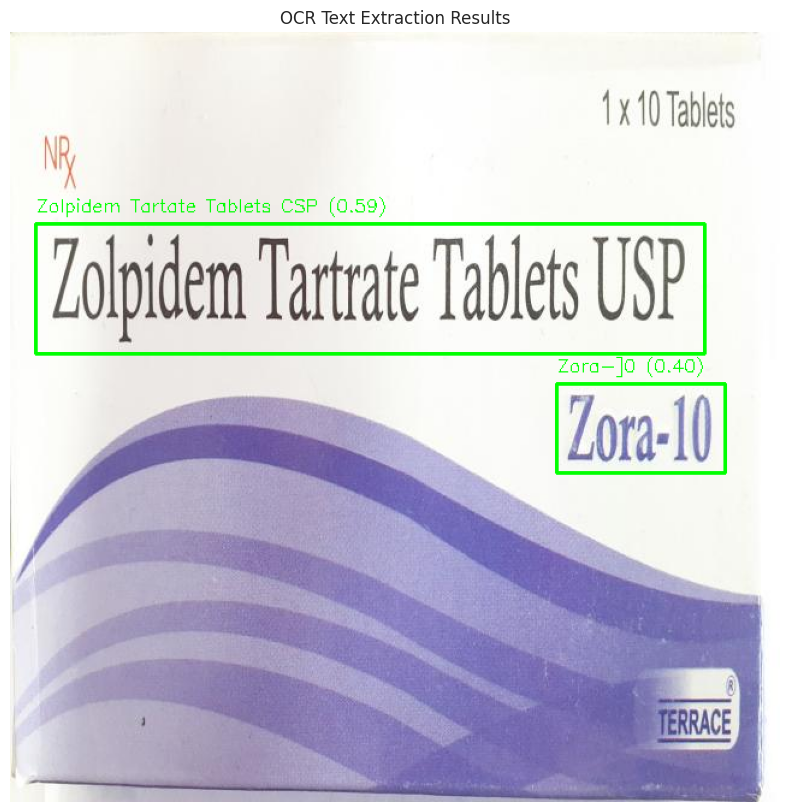

EXTRACTED MEDICINE INFORMATION:
Generic Name: Zora-]0
Dosage Form: Tablets

MEDICINE-RELATED TEXT:
1. Zolpidem Tartate Tablets CSP

OCR Processing Successful!
Average Confidence: 0.587


In [77]:
# [Cell 14]: Image Upload and Processing Interface
from google.colab import files
import io

def upload_and_process_medicine_image():
    """Upload medicine label image and process it"""

    print("MEDICINE LABEL IMAGE UPLOAD")
    print("="*50)
    print("Please upload a clear image of the medicine label")

    # Upload image
    uploaded = files.upload()

    if not uploaded:
        print("No image uploaded. Please try again.")
        return None

    # Get the uploaded file
    image_name = list(uploaded.keys())[0]
    image_data = uploaded[image_name]

    print(f"\nProcessing image: {image_name}")
    print(f"File size: {len(image_data)} bytes")

    # Create file-like object from uploaded data
    image_file = io.BytesIO(image_data)

    # Process with OCR
    ocr_result = ocr_processor.extract_medicine_info(image_file, display_result=True)

    if ocr_result['success']:
        print(f"\nOCR Processing Successful!")
        print(f"Average Confidence: {ocr_result['confidence_avg']:.3f}")
        return ocr_result
    else:
        print(f"\nOCR Processing Failed: {ocr_result['error']}")
        return None

# Test the upload functionality
# Uncomment the line below to test image upload
ocr_result = upload_and_process_medicine_image()

# Complete Prediction Pipeline with Image Support


In [94]:
import sqlite3 # Import the sqlite3 library
import pandas as pd
import numpy as np
import re
import json
from datetime import datetime
import pickle # Import the pickle library
import joblib # Import the joblib library

class MedicineDisposalPredictor:
    """Complete pipeline for medicine disposal prediction with image support"""

    def __init__(self, model_path='/content/drive/MyDrive/UmutiSafe/models/'):
        self.model_path = model_path
        self.ocr_processor = MedicineOCRProcessor()
        self.load_models()
        self.db_connection = sqlite3.connect('/content/drive/MyDrive/UmutiSafe/data/processed/disposal_guidance.db')

    def load_models(self):
        """Load trained models and preprocessing objects"""
        try:
            with open(f'{self.model_path}model_metadata.json', 'r') as f:
                self.metadata = json.load(f)

            # Load best model
            best_model_file = f"{self.model_path}{self.metadata['best_category_model']}.pkl" # Corrected model file name
            with open(best_model_file, 'rb') as f:
                self.model = pickle.load(f)


            self.label_encoder = joblib.load(f'{self.model_path}le_category.pkl') # Assuming le_category was saved



            print("All models loaded successfully")

        except FileNotFoundError as e:
             print(f"Error loading models: {e}. Make sure all required files are in the models folder.")
             raise
        except Exception as e:
            print(f"Error loading models: {e}")
            raise

    def predict_from_image(self, uploaded_image):
        """Predict disposal category from uploaded medicine label image"""

        print("Processing medicine label image...")

        # Extract text from image
        ocr_result = self.ocr_processor.extract_medicine_info(uploaded_image, display_result=True)

        if not ocr_result['success']:
            return {
                'success': False,
                'error': f"OCR processing failed: {ocr_result.get('error', 'Unknown error')}",
                'ocr_info': ocr_result
            }

        extracted_info = ocr_result['extracted_info']

        # Use extracted information for prediction
        if not extracted_info['generic_name'] and extracted_info['active_ingredients']:
            # Use first active ingredient as generic name if no generic name found
            extracted_info['generic_name'] = extracted_info['active_ingredients'][0]

        # Create medicine data for prediction
        medicine_data = pd.DataFrame([{
            'Generic Name': extracted_info['generic_name'] or 'Unknown Medicine',
            'Product Brand Name': extracted_info['brand_name'] or '',
            'Dosage Form': extracted_info['dosage_form'] or '',
            'Packaging Type': 'Unknown'  # Default, can be improved
        }])

        # Predict disposal category
        disposal_category, confidence, probabilities = self.predict_disposal(medicine_data)

        # Get safety guidelines
        guidelines = self.get_disposal_guidelines(disposal_category, show_full=False)

        # Create comprehensive response
        response = {
            'success': True,
            'ocr_processing': {
                'confidence': ocr_result['confidence_avg'],
                'extracted_info': extracted_info,
                'medicine_text_found': len(ocr_result['medicine_text']) > 0
            },
            'medicine_info': extracted_info,
            'prediction': {
                'disposal_category': disposal_category,
                'confidence': round(confidence, 3),
                'all_probabilities': {
                    self.label_encoder.classes_[i]: round(prob, 3)
                    for i, prob in enumerate(probabilities)
                }
            },
            'safety_guidance': guidelines,
            'timestamp': datetime.now().isoformat()
        }

        return response

    def predict_disposal(self, medicine_data):
        """Predict disposal category for medicine data"""


        combined_text = (medicine_data['Product Brand Name'].astype(str) + ' ' +
                         medicine_data['Generic Name'].astype(str) + ' ' +
                         medicine_data['Dosage Form'].astype(str) + ' ' +
                         medicine_data['Packaging Type'].astype(str))

        # TF-IDF features
        X_text_tfidf = tfidf.transform(combined_text) # Assuming tfidf is loaded

        # Text statistics
        word_count = combined_text.apply(lambda x: len(str(x).split()))
        char_count = combined_text.apply(lambda x: len(str(x)))
        special_chars = combined_text.apply(lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', str(x))))
        text_features_df = pd.DataFrame({
            'word_count': word_count,
            'char_count': char_count,
            'special_chars': special_chars
        })

        X = np.hstack((X_text_tfidf.toarray(), text_features_df.values))
        prediction_encoded = self.model.predict(X)[0]

        # Get probabilities
        prediction_proba = self.model.predict_proba(X)[0]


        # Decode prediction
        disposal_category = self.le_category.inverse_transform([prediction_encoded])[0] # Assuming le_category is loaded
        confidence = prediction_proba[prediction_encoded]

        return disposal_category, confidence, prediction_proba


    def get_disposal_guidelines(self, category, show_full=False):
        """Get disposal guidelines from database"""

        cursor = self.db_connection.cursor()

        # Check if the disposal_guidelines table exists
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='disposal_guidelines';")
        table_exists = cursor.fetchone() is not None

        if not table_exists:
            print("Warning: 'disposal_guidelines' table not found in the database.")
            return None # Or return a default guideline structure

        if show_full:
            cursor.execute('''
                SELECT category, risk_level, prohibitions, risks, procedure, special_instructions
                FROM disposal_guidelines WHERE category = ?
            ''', (category,))
        else:
            cursor.execute('''
                SELECT category, risk_level, prohibitions, risks
                FROM disposal_guidelines WHERE category = ?
            ''', (category,))

        result = cursor.fetchone()

        if result:
            # Assuming column order matches the SELECT statement
            guideline_data = {
                'category': result[0],
                'risk_level': result[1],
                'prohibitions': result[2], # Note: These are strings, might need parsing if stored as lists
                'risks': result[3],       # Note: These are strings, might need parsing if stored as lists
            }
            if show_full:
                guideline_data['procedure'] = result[4] # String, might need parsing
                guideline_data['special_instructions'] = result[5] # String, might need parsing

            # Attempt to retrieve category name and icon from the imported disposal_guidelines dictionary
            # Assuming the category in the DB matches the keys in the dictionary
            if category in disposal_guidelines: # Check if category exists in the imported dictionary
                 guideline_data['category_name'] = disposal_guidelines[category].get('category_name', 'Unknown Category')
                 guideline_data['icon'] = disposal_guidelines[category].get('icon', '💊')


            return guideline_data
        return None # Return None if no guideline found for the category


    def process_text_input(self, generic_name, brand_name="", dosage_form="", packaging_type=""):
        """Process text input and return disposal guidance"""

        # Create input data
        medicine_data = pd.DataFrame([{
            'Generic Name': generic_name,
            'Product Brand Name': brand_name,
            'Dosage Form': dosage_form,
            'Packaging Type': packaging_type
        }])

        # Predict disposal category
        disposal_category, confidence, probabilities = self.predict_disposal(medicine_data)

        # Get guidelines
        guidelines = self.get_disposal_guidelines(disposal_category, show_full=False)

        # Create comprehensive response
        response = {
            'medicine_info': {
                'generic_name': generic_name,
                'brand_name': brand_name,
                'dosage_form': dosage_form
            },
            'classification': {
                'disposal_category': disposal_category,
                'confidence': round(confidence, 3),
                'all_probabilities': {
                    self.le_category.classes_[i]: round(prob, 3)
                    for i, prob in enumerate(probabilities)
                 }
            },
            'safety_guidance': guidelines,
            'timestamp': datetime.now().isoformat()
        }

        return response

print("MedicineDisposalPredictor class defined.")

MedicineDisposalPredictor class defined.


Disposal guidelines database created successfully.
Total categories: 5
  Category 1: Solids (Tablets, Capsules, Powders)
  Category 2: Liquids (Solutions, Injections, Syrups)
  Category 3: Semisolids (Creams, Ointments, Gels)
  Category 4: Aerosols and Inhalers
  Category 5: Biological Waste (Vaccines, Blood Products)
✅ Disposal guidelines database loaded successfully
📋 Sample guideline structure for '1':
   Type: <class 'dict'>
   category_name: <class 'str'> - Solids (Tablets, Capsules, Powders)
   icon: <class 'str'> - 
   quick_summary: <class 'dict'> - {'safe_method': 'Encapsulate and dispose in secure landfill or incinerate.', 'time_required': '30-60 minutes (per batch)', 'can_diy': True}
   steps: <class 'list'> - [{'step': 1, 'title': 'Preparation and Sorting', 'actions': ['Wear appropriate Personal Protective Equipment (PPE): gloves, mask, and protective gown', 'Sort expired or unused tablets separately from regular waste', 'Check expiry dates and verify medicine names', 'Docu

✅ Feature importance data loaded
✅ All system components loaded successfully
✅ Rwanda FDA dataset loaded for medicine matching
✅ System ready!

 TESTING OPTIONS

1. 📷 Image Input (Upload medicine label)
2. ⌨️  Text Input (Enter medicine details)
3. ⚡ Quick Tests
4. 📋 Guidelines
5. 🚪 Exit

Select option (1-5): 1

📷 IMAGE UPLOAD MODE
Please upload a clear image of the medicine label


Saving metoclopramide_jpg.rf.9413b919220c32f9095bd17e797c8cea.jpg to metoclopramide_jpg.rf.9413b919220c32f9095bd17e797c8cea (2).jpg

🔄 Processing: metoclopramide_jpg.rf.9413b919220c32f9095bd17e797c8cea (2).jpg

🔄 PROCESSING MEDICINE LABEL...

🖼️  ORIGINAL UPLOADED IMAGE


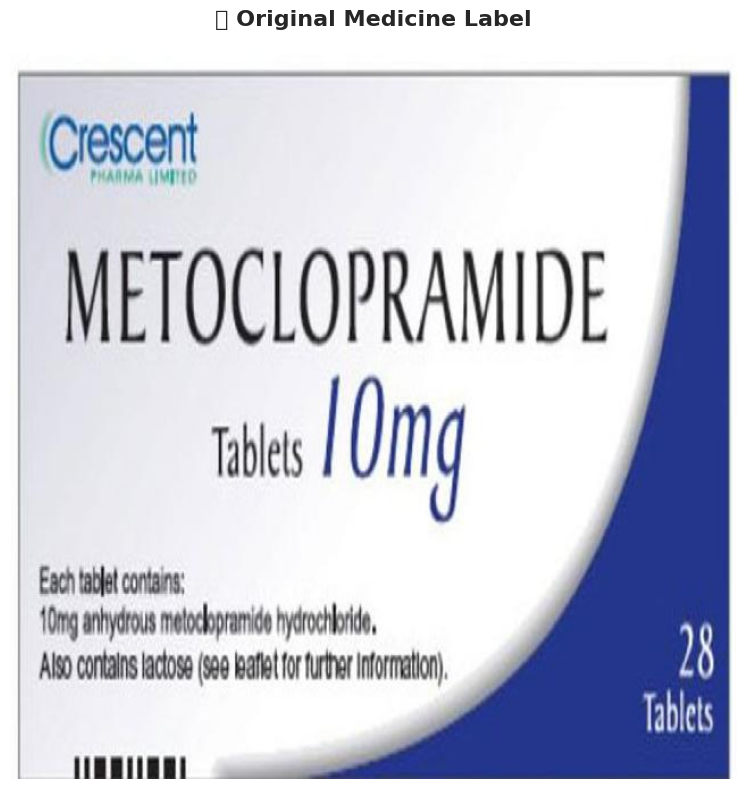


🔍 OCR PROCESSED IMAGE
🟢 Green boxes: All detected text
🔵 Blue boxes: Medicine-related text (high importance)
📊 Numbers: OCR confidence scores


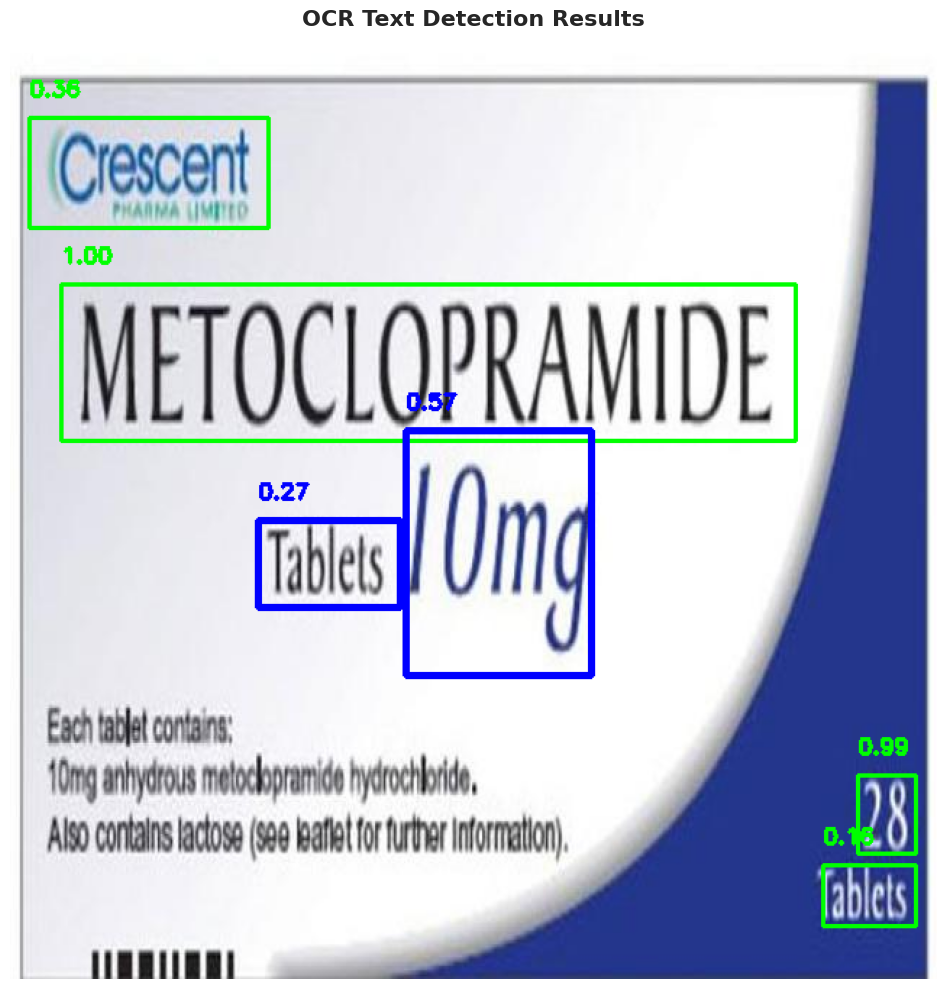


📋 EXTRACTED MEDICINE INFORMATION
🔹 Brand Name: METOCLOPRAMIDE

🔍 Medicine-related text found (2 items):
   1. 'Tablels' (confidence: 0.27)
   2. 'IUmg' (confidence: 0.57)

📊 OCR Confidence: 0.56

🎯 DISPOSAL CLASSIFICATION RESULTS

💊 MEDICINE INFORMATION:
   • Generic Name: Unknown Medicine
   • Brand Name: METOCLOPRAMIDE

📊 PREDICTION RESULTS:
   • Disposal Category: 1
   • Risk Level: LOW
   • Confidence: 48.4%

   📈 Category Probabilities:
      1: 48.4%
      2: 31.4%
      3: 19.0%

⚠️  SAFETY GUIDANCE:
   • Risk Level: LOW

   🚫 PROHIBITIONS:
      • Do NOT flush tablets down toilet or sink (unless specifically listed in FDA flush list)
      • Do NOT burn in open air or low-temperature incinerators
      • Do NOT dispose in regular household waste without encapsulation
      • Do NOT mix with infectious or sharp waste
      • Do NOT crush or pulverize high-risk drugs without proper containment
      • Do NOT dispose in water bodies or drainage systems

📷 OCR PROCESSING:
   • Ove

In [107]:
# STEP 6: Fixed Integrated Testing Interface

from google.colab import files
import io
import pandas as pd
import numpy as np
import re
import json
from datetime import datetime
import pickle
import joblib
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import easyocr
import sqlite3
import os

# Load the disposal guidelines from your Python file
try:
    disposal_guidelines_db_path = '/content/drive/MyDrive/UmutiSafe/data/processed/disposal_guidelines_db.py'
    if os.path.exists(disposal_guidelines_db_path):
        with open(disposal_guidelines_db_path, 'r') as f:
            disposal_db_content = f.read()
        # Execute the file to load the disposal_guidelines dictionary
        exec(disposal_db_content)
        print("✅ Disposal guidelines database loaded successfully")

        # Debug: Print the structure of the first guideline to understand the format
        if disposal_guidelines and len(disposal_guidelines) > 0:
            first_key = list(disposal_guidelines.keys())[0]
            print(f"📋 Sample guideline structure for '{first_key}':")
            print(f"   Type: {type(disposal_guidelines[first_key])}")
            if isinstance(disposal_guidelines[first_key], dict):
                for k, v in disposal_guidelines[first_key].items():
                    print(f"   {k}: {type(v)} - {v}")
    else:
        print("⚠️  Disposal guidelines file not found")
        disposal_guidelines = {}
except Exception as e:
    print(f"⚠️  Error loading disposal guidelines: {e}")
    disposal_guidelines = {}

class EnhancedOCRProcessor:
    """OCR processor optimized for medicine label extraction"""

    def __init__(self):
        self.reader = easyocr.Reader(['en'])
        # Comprehensive medicine-related keywords - EXPANDED
        self.medicine_keywords = [
            # Dosage forms - EXPANDED
            'tablet', 'capsule', 'injection', 'solution', 'suspension', 'cream', 'ointment',
            'syrup', 'drops', 'spray', 'inhaler', 'patch', 'suppository', 'powder', 'liquid',
            'pill', 'caps', 'cap', 'tab', 'inj', 'sol', 'susp', 'ampoule', 'vial', 'ampule',
            'injectable', 'infusion', 'emulsion', 'gel', 'lotion', 'liniment', 'paste',
            'aerosol', 'nebulizer', 'implant', 'pellet', 'granules', 'sachet', 'cachet',

            # Units and measurements
            'mg', 'ml', 'mcg', 'iu', 'g', 'gram', 'milligram', 'microgram', 'unit', '%', 'ppm',
            'milliliter', 'liter', 'international', 'units', 'cc', 'cm³', 'kilogram', 'kg',

            # Medicine-related terms
            'strength', 'dose', 'dosage', 'contains', 'ingredients', 'active', 'composition',
            'formula', 'prescription', 'medicine', 'drug', 'pharmaceutical', 'therapy',
            'treatment', 'medication', 'pill', 'drops', 'bottle', 'vial', 'ampoule',
            'blister', 'pack', 'strip', 'bottle', 'container', 'pharmacy', 'dispense',
            'administer', 'apply', 'inject', 'oral', 'topical', 'parenteral', 'intravenous',
            'intramuscular', 'subcutaneous', 'ophthalmic', 'otic', 'nasal', 'rectal', 'vaginal',

            # Common medicine names from Rwanda FDA dataset - EXPANDED
            'paracetamol', 'amoxicillin', 'ibuprofen', 'aspirin', 'insulin', 'morphine', 'warfarin',
            'metformin', 'diazepam', 'codeine', 'ciprofloxacin', 'levothyroxine', 'atorvastatin',
            'simvastatin', 'omeprazole', 'losartan', 'metoprolol', 'amlodipine', 'prednisone',
            'hydrochlorothiazide', 'lisinopril', 'albuterol', 'fluoxetine', 'sertraline',
            'glimepiride', 'gliclazide', 'aflibercept', 'moxifloxacin', 'perindopril',
            'indapamide', 'doxorubicin', 'cisplatin', 'fluorouracil', 'cyclophosphamide',
            'vincristine', 'buprenorphine', 'oxycodone', 'methylphenidate', 'heparin',
            'rivaroxaban', 'ceftriaxone', 'azithromycin', 'clindamycin', 'doxycycline',
            'erythromycin', 'gentamicin', 'vancomycin', 'phenytoin', 'carbamazepine',
            'valproate', 'lamotrigine', 'furosemide', 'spironolactone', 'digoxin',
            'nitroglycerin', 'salbutamol', 'beclomethasone', 'fluticasone', 'montelukast',
            'loratadine', 'cetirizine', 'ranitidine', 'cimetidine', 'pantoprazole',
            'esomeprazole', 'bisacodyl', 'loperamide', 'senna', 'lactulose'
        ]

    def display_uploaded_image(self, image_data, title="Uploaded Image"):
        """Display the original uploaded image"""
        plt.figure(figsize=(10, 8))

        if isinstance(image_data, np.ndarray):
            image_rgb = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
        else:
            image_array = np.frombuffer(image_data, np.uint8)
            image_rgb = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
            image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)

        plt.imshow(image_rgb)
        plt.title(f"📷 {title}", fontsize=16, fontweight='bold', pad=20)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        return image_rgb

    def extract_text_with_visualization(self, image_data):
        """Extract text with comprehensive visualization"""

        # Convert and display original image
        if isinstance(image_data, bytes):
            image_array = np.frombuffer(image_data, np.uint8)
            original_image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
        else:
            original_image = image_data

        # Display original image
        print("\n" + "🖼️  ORIGINAL UPLOADED IMAGE")
        print("="*50)
        original_rgb = self.display_uploaded_image(original_image, "Original Medicine Label")

        # Enhanced preprocessing
        gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        denoised = cv2.medianBlur(gray, 5)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(denoised)
        _, processed_image = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Perform OCR with lower confidence threshold
        results = self.reader.readtext(processed_image, detail=1, paragraph=False)

        # Create visualization
        annotated_image = original_image.copy()
        medicine_texts = []
        all_texts = []

        for (bbox, text, confidence) in results:
            if confidence > 0.1:  # Lower threshold for more text capture
                text_clean = text.strip()
                if len(text_clean) > 1:
                    all_texts.append({'text': text_clean, 'confidence': confidence, 'bbox': bbox})

                    # Draw bounding box
                    top_left = tuple(map(int, bbox[0]))
                    bottom_right = tuple(map(int, bbox[2]))

                    # Enhanced medicine detection
                    is_medicine_related = self._is_medicine_related(text_clean)

                    if is_medicine_related:
                        medicine_texts.append({'text': text_clean, 'confidence': confidence})
                        color = (255, 0, 0)  # Blue for medicine-related
                        thickness = 3
                    else:
                        color = (0, 255, 0)  # Green for other text
                        thickness = 2

                    cv2.rectangle(annotated_image, top_left, bottom_right, color, thickness)
                    cv2.putText(annotated_image, f'{confidence:.2f}',
                               (top_left[0], top_left[1] - 15),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Display annotated image
        print("\n" + "🔍 OCR PROCESSED IMAGE")
        print("="*50)
        print("🟢 Green boxes: All detected text")
        print("🔵 Blue boxes: Medicine-related text (high importance)")
        print("📊 Numbers: OCR confidence scores")

        annotated_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12, 10))
        plt.imshow(annotated_rgb)
        plt.title("OCR Text Detection Results", fontsize=16, fontweight='bold', pad=20)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        # Extract structured information
        extracted_info = self._extract_medicine_info(all_texts)

        return {
            'success': True,
            'extracted_info': extracted_info,
            'medicine_texts': medicine_texts,
            'all_texts': all_texts,
            'confidence_avg': np.mean([t['confidence'] for t in all_texts]) if all_texts else 0,
            'original_image': original_rgb,
            'annotated_image': annotated_rgb
        }

    def _is_medicine_related(self, text):
        """Enhanced medicine text detection"""
        text_lower = text.lower()

        # Check for medicine keywords
        if any(keyword in text_lower for keyword in self.medicine_keywords):
            return True

        # Check for dosage patterns
        if re.search(r'\d+\s*(?:mg|mcg|ml|g|%|iu|units?)', text_lower):
            return True

        # Check for common medicine patterns
        if re.search(r'[a-z]+\d*[a-z]*\s*\d+', text_lower):
            return True

        return False

    def _extract_medicine_info(self, ocr_results):
        """Extract structured medicine information"""
        info = {
            'generic_name': '',
            'brand_name': '',
            'dosage_strength': '',
            'dosage_form': '',
            'active_ingredients': [],
            'manufacturer': '',
            'other_info': []
        }

        all_text = ' '.join([item['text'] for item in ocr_results])
        individual_texts = [item['text'] for item in ocr_results]

        # Enhanced dosage strength extraction
        strength_patterns = [
            r'(\d+\s*(?:mg|mcg|ml|g|%))',
            r'(\d+\s*mg/\s*ml)',
            r'(\d+\s*IU)',
            r'(\d+\s*units?)',
            r'strength\s*[:]?\s*(\d+\s*(?:mg|mcg|ml))',
            r'(\d+\s*mg\s*tablet)',
            r'(\d+\s*mg\s*capsule)',
            r'(\d+\s*mg/\s*\d+\s*ml)',  # Added ratio patterns
            r'(\d+\s*mcg/\s*actuation)'  # Added for sprays/inhalers
        ]

        for pattern in strength_patterns:
            matches = re.findall(pattern, all_text, re.IGNORECASE)
            if matches:
                info['dosage_strength'] = matches[0]
                break

        # Enhanced medicine name extraction - EXPANDED
        common_meds = [
            'paracetamol', 'amoxicillin', 'ibuprofen', 'aspirin', 'metformin',
            'insulin', 'morphine', 'warfarin', 'diazepam', 'codeine', 'ciprofloxacin',
            'levothyroxine', 'atorvastatin', 'simvastatin', 'omeprazole', 'losartan',
            'glimepiride', 'gliclazide', 'aflibercept', 'moxifloxacin', 'perindopril',
            'ceftriaxone', 'azithromycin', 'clindamycin', 'doxycycline', 'gentamicin',
            'vancomycin', 'phenytoin', 'carbamazepine', 'valproate', 'furosemide',
            'spironolactone', 'digoxin', 'nitroglycerin', 'salbutamol', 'loratadine',
            'cetirizine', 'ranitidine', 'pantoprazole'
        ]

        for text in individual_texts:
            text_lower = text.lower()

            # Check for medicine names
            for med in common_meds:
                if med in text_lower and med.capitalize() not in info['active_ingredients']:
                    info['active_ingredients'].append(med.capitalize())
                    if not info['generic_name']:
                        info['generic_name'] = med.capitalize()

            # Extract potential brand names
            if (text.isupper() and 2 < len(text) < 25 and
                not any(char.isdigit() for char in text) and
                text not in ['ML', 'MG', 'MCG', 'IU', 'BP', 'USP', 'FDA']):
                info['brand_name'] = text

            # Extract manufacturer information
            if any(keyword in text_lower for keyword in ['ltd', 'inc', 'corporation', 'pharma', 'laboratories', 'company', 'laboratoire']):
                info['manufacturer'] = text

        # If no generic name found but we have active ingredients, use the first one
        if not info['generic_name'] and info['active_ingredients']:
            info['generic_name'] = info['active_ingredients'][0]

        # Extract dosage form - EXPANDED
        dosage_forms = ['tablet', 'capsule', 'injection', 'solution', 'suspension',
                       'cream', 'ointment', 'syrup', 'drops', 'spray', 'ampoule',
                       'vial', 'injectable', 'infusion', 'emulsion', 'gel', 'lotion',
                       'inhaler', 'patch', 'suppository', 'powder', 'liquid']
        for form in dosage_forms:
            if form in all_text.lower():
                info['dosage_form'] = form.capitalize()
                break

        # Collect other potentially relevant information
        for text in individual_texts:
            if (len(text) > 8 and
                not any(keyword in text.lower() for keyword in ['www', 'http', '.com']) and
                text not in info.values() and text not in info['active_ingredients']):
                info['other_info'].append(text)

        return info

class MedicineDisposalPredictor:
    """Complete predictor using all saved components"""

    def __init__(self, components):
        self.components = components
        self.ocr_processor = EnhancedOCRProcessor()

        # Load Rwanda FDA dataset for matching
        try:
            self.rwanda_fda_df = pd.read_csv('/content/drive/MyDrive/UmutiSafe/data/raw/rwanda_fda_medicines.csv')
            print("✅ Rwanda FDA dataset loaded for medicine matching")
        except Exception as e:
            print(f"⚠️  Could not load Rwanda FDA dataset: {e}")
            self.rwanda_fda_df = None

    def predict_from_image(self, uploaded_image):
        """Predict disposal from uploaded image"""

        print("\n" + "🔄 PROCESSING MEDICINE LABEL...")
        print("="*50)

        # Extract text with visualization
        ocr_result = self.ocr_processor.extract_text_with_visualization(uploaded_image)

        if not ocr_result['success']:
            return self._create_error_response("OCR processing failed")

        # Display extracted information
        self._display_extracted_info(ocr_result)

        # Use extracted info for prediction
        extracted_info = ocr_result['extracted_info']

        # Try to match with Rwanda FDA dataset
        matched_medicine = self._match_with_fda_dataset(extracted_info)

        # Create prediction data
        if matched_medicine:
            generic_name = matched_medicine['Generic Name']
            dosage_form = matched_medicine['Dosage Form']
            brand_name = matched_medicine.get('Product Brand Name', '')
        else:
            # Use OCR extracted info
            generic_name = extracted_info['generic_name'] or "Unknown Medicine"
            if extracted_info['dosage_strength']:
                generic_name += f" {extracted_info['dosage_strength']}"
            dosage_form = extracted_info.get('dosage_form', '')
            brand_name = extracted_info.get('brand_name', '')

        medicine_data = pd.DataFrame([{
            'Generic Name': generic_name,
            'Product Brand Name': brand_name,
            'Dosage Form': dosage_form,
            'Packaging Type': 'Unknown'
        }])

        # Get predictions using saved models
        category_pred, risk_pred, probabilities = self._get_predictions(medicine_data)

        # Get guidelines
        guidelines = self._get_disposal_guidelines(category_pred, risk_pred)

        # Create comprehensive response
        response = {
            'success': True,
            'ocr_info': {
                'confidence': ocr_result['confidence_avg'],
                'extracted_info': extracted_info,
                'medicine_texts_found': len(ocr_result['medicine_texts']),
                'fda_matched': matched_medicine is not None
            },
            'medicine_info': {
                'generic_name': generic_name,
                'brand_name': brand_name,
                'dosage_form': dosage_form,
                'matched_from_fda': matched_medicine is not None
            },
            'predictions': {
                'disposal_category': category_pred,
                'risk_level': risk_pred,
                'confidence': max(probabilities.values()) if probabilities else 0,
                'all_probabilities': probabilities
            },
            'safety_guidance': guidelines,
            'visualization': {
                'original_image': ocr_result['original_image'],
                'annotated_image': ocr_result['annotated_image']
            },
            'timestamp': datetime.now().isoformat()
        }

        return response

    def _match_with_fda_dataset(self, extracted_info):
        """Try to match extracted info with Rwanda FDA dataset"""
        if self.rwanda_fda_df is None or not extracted_info['generic_name']:
            return None

        try:
            generic_name = extracted_info['generic_name'].lower()

            # Search for matches in generic name
            matches = self.rwanda_fda_df[
                self.rwanda_fda_df['Generic Name'].str.contains(generic_name, case=False, na=False)
            ]

            if len(matches) > 0:
                print(f"✅ Matched with Rwanda FDA dataset: {len(matches)} potential matches")
                return matches.iloc[0].to_dict()

            # Search in active ingredients
            for ingredient in extracted_info['active_ingredients']:
                matches = self.rwanda_fda_df[
                    self.rwanda_fda_df['Generic Name'].str.contains(ingredient.lower(), case=False, na=False)
                ]
                if len(matches) > 0:
                    print(f"✅ Matched via active ingredient: {ingredient}")
                    return matches.iloc[0].to_dict()

        except Exception as e:
            print(f"⚠️  Error matching with FDA dataset: {e}")

        return None

    def _display_extracted_info(self, ocr_result):
        """Display extracted information"""
        print("\n" + "📋 EXTRACTED MEDICINE INFORMATION")
        print("="*50)

        info = ocr_result['extracted_info']
        medicine_texts = ocr_result['medicine_texts']

        items_displayed = 0
        if info['generic_name']:
            print(f"🔹 Generic Name: {info['generic_name']}")
            items_displayed += 1
        if info['brand_name']:
            print(f"🔹 Brand Name: {info['brand_name']}")
            items_displayed += 1
        if info['dosage_strength']:
            print(f"🔹 Dosage Strength: {info['dosage_strength']}")
            items_displayed += 1
        if info['active_ingredients']:
            print(f"🔹 Active Ingredients: {', '.join(info['active_ingredients'])}")
            items_displayed += 1
        if info['dosage_form']:
            print(f"🔹 Dosage Form: {info['dosage_form']}")
            items_displayed += 1
        if info['manufacturer']:
            print(f"🔹 Manufacturer: {info['manufacturer']}")
            items_displayed += 1

        if items_displayed == 0:
            print("🔸 No specific medicine information extracted")
            if info['other_info']:
                print(f"🔸 Other detected text: {', '.join(info['other_info'][:5])}")

        if medicine_texts:
            print(f"\n🔍 Medicine-related text found ({len(medicine_texts)} items):")
            for i, item in enumerate(medicine_texts[:6], 1):
                print(f"   {i}. '{item['text']}' (confidence: {item['confidence']:.2f})")

        print(f"\n📊 OCR Confidence: {ocr_result['confidence_avg']:.2f}")

    def _get_predictions(self, medicine_data):
        """Get predictions using saved models - FIXED for risk prediction"""
        try:
            # Combine text features as per training
            combined_text = (medicine_data['Product Brand Name'].astype(str) + ' ' +
                            medicine_data['Generic Name'].astype(str) + ' ' +
                            medicine_data['Dosage Form'].astype(str) + ' ' +
                            medicine_data['Packaging Type'].astype(str))

            # TF-IDF features using saved vectorizer
            tfidf = self.components['tfidf_vectorizer']
            X_text_tfidf = tfidf.transform(combined_text)

            # Text statistics
            word_count = combined_text.apply(lambda x: len(str(x).split()))
            char_count = combined_text.apply(lambda x: len(str(x)))
            special_chars = combined_text.apply(lambda x: len(re.findall(r'[^a-zA-Z0-9\s]', str(x))))

            text_features_df = pd.DataFrame({
                'word_count': word_count,
                'char_count': char_count,
                'special_chars': special_chars
            })

            # Combine features
            X = np.hstack((X_text_tfidf.toarray(), text_features_df.values))

            # Predict category using saved model
            category_model = self.components['category_model']
            le_category = self.components['le_category']

            category_pred_encoded = category_model.predict(X)[0]
            category_proba = category_model.predict_proba(X)[0]
            category_pred = le_category.inverse_transform([category_pred_encoded])[0]

            # Predict risk level using the risk model
            risk_model = self.components['risk_model']
            le_risk = self.components['le_risk']

            risk_pred_encoded = risk_model.predict(X)[0]
            risk_proba = risk_model.predict_proba(X)[0]
            risk_pred = le_risk.inverse_transform([risk_pred_encoded])[0]

            # Create probabilities dictionary for categories
            probabilities = {
                le_category.classes_[i]: round(prob, 3)
                for i, prob in enumerate(category_proba)
            }

            return category_pred, risk_pred, probabilities

        except Exception as e:
            print(f"❌ Prediction error: {e}")
            return "Unknown", "Unknown", {}

    def _get_disposal_guidelines(self, category, risk_level):
        """Get disposal guidelines using saved database - FIXED VERSION"""
        try:
            # Use the disposal_guidelines dictionary from your saved file
            if category in disposal_guidelines:
                guideline_data = disposal_guidelines[category].copy()

                # Handle different data types for prohibitions and risks
                if isinstance(guideline_data.get('prohibitions'), list):
                    # If prohibitions is a list, convert to string
                    guideline_data['prohibitions'] = '. '.join(guideline_data['prohibitions'])

                if isinstance(guideline_data.get('risks'), list):
                    # If risks is a list, convert to string
                    guideline_data['risks'] = '. '.join(guideline_data['risks'])

                # Add risk-specific information
                guideline_data['risk_level'] = risk_level
                return guideline_data
            else:
                return self._get_fallback_guidelines(category, risk_level)

        except Exception as e:
            print(f"⚠️  Error accessing guidelines: {e}")
            return self._get_fallback_guidelines(category, risk_level)

    def _get_fallback_guidelines(self, category, risk_level):
        """Fallback guidelines"""
        return {
            'category_name': category,
            'risk_level': risk_level,
            'prohibitions': 'Follow general medicine disposal guidelines. Consult healthcare provider for specific instructions.',
            'risks': 'Unknown risks. Professional guidance recommended for safe disposal.',
            'procedure': 'Contact local pharmacy or healthcare facility for disposal instructions.',
            'special_instructions': 'Always prioritize safety and environmental protection.'
        }

    def process_text_input(self, generic_name, brand_name="", dosage_form="", packaging_type=""):
        """Process text input"""

        medicine_data = pd.DataFrame([{
            'Generic Name': generic_name,
            'Product Brand Name': brand_name,
            'Dosage Form': dosage_form,
            'Packaging Type': packaging_type
        }])

        # Get predictions
        category_pred, risk_pred, probabilities = self._get_predictions(medicine_data)

        # Get guidelines
        guidelines = self._get_disposal_guidelines(category_pred, risk_pred)

        response = {
            'success': True,
            'medicine_info': {
                'generic_name': generic_name,
                'brand_name': brand_name,
                'dosage_form': dosage_form
            },
            'predictions': {
                'disposal_category': category_pred,
                'risk_level': risk_pred,
                'confidence': max(probabilities.values()) if probabilities else 0,
                'all_probabilities': probabilities
            },
            'safety_guidance': guidelines,
            'timestamp': datetime.now().isoformat()
        }

        return response

    def _create_error_response(self, message):
        return {
            'success': False,
            'error': message,
            'timestamp': datetime.now().isoformat()
        }

def load_system_components():
    """Load all system components"""
    try:
        base_path = '/content/drive/MyDrive/UmutiSafe/models/'

        components = {
            'category_model': joblib.load(f'{base_path}best_category_model.pkl'),
            'risk_model': joblib.load(f'{base_path}best_risk_model.pkl'),
            'le_category': joblib.load(f'{base_path}le_category.pkl'),
            'le_risk': joblib.load(f'{base_path}le_risk.pkl'),
            'tfidf_vectorizer': joblib.load(f'{base_path}tfidf_vectorizer.pkl')
        }

        # Load feature importance for insights
        feature_importance_path = '/content/drive/MyDrive/UmutiSafe/outputs/results/feature_importance.csv'
        if os.path.exists(feature_importance_path):
            components['feature_importance'] = pd.read_csv(feature_importance_path)
            print("✅ Feature importance data loaded")

        print("✅ All system components loaded successfully")
        return components

    except Exception as e:
        print(f"❌ Error loading components: {e}")
        return None

def display_prediction_results(result):
    """Display results in structured format - FIXED VERSION"""

    if not result.get('success', False):
        print(f"\n❌ PROCESSING FAILED: {result.get('error', 'Unknown error')}")
        return

    print("\n" + "🎯 DISPOSAL CLASSIFICATION RESULTS")
    print("="*60)

    # Medicine Information
    medicine_info = result.get('medicine_info', {})
    if medicine_info:
        print("\n💊 MEDICINE INFORMATION:")
        if medicine_info.get('generic_name'):
            print(f"   • Generic Name: {medicine_info['generic_name']}")
        if medicine_info.get('brand_name'):
            print(f"   • Brand Name: {medicine_info['brand_name']}")
        if medicine_info.get('dosage_form'):
            print(f"   • Dosage Form: {medicine_info['dosage_form']}")
        if medicine_info.get('matched_from_fda'):
            print(f"   • Source: ✅ Matched with Rwanda FDA database")

    # Predictions
    predictions = result.get('predictions', {})
    if predictions:
        print(f"\n📊 PREDICTION RESULTS:")
        print(f"   • Disposal Category: {predictions.get('disposal_category', 'Unknown')}")
        print(f"   • Risk Level: {predictions.get('risk_level', 'Unknown')}")
        print(f"   • Confidence: {predictions.get('confidence', 0):.1%}")

        # Show top probabilities
        all_probs = predictions.get('all_probabilities', {})
        if all_probs:
            print(f"\n   📈 Category Probabilities:")
            sorted_probs = sorted(all_probs.items(), key=lambda x: x[1], reverse=True)[:3]
            for category, prob in sorted_probs:
                if prob > 0.1:
                    print(f"      {category}: {prob:.1%}")

    # Safety Guidance - FIXED: Handle both strings and lists properly
    guidance = result.get('safety_guidance', {})
    if guidance:
        print(f"\n⚠️  SAFETY GUIDANCE:")
        print(f"   • Risk Level: {guidance.get('risk_level', 'Not specified')}")

        if guidance.get('prohibitions'):
            print(f"\n   🚫 PROHIBITIONS:")
            prohibitions = guidance['prohibitions']
            # Handle both string and list formats
            if isinstance(prohibitions, str):
                # Split string by periods
                prohibition_list = [p.strip() for p in prohibitions.split('.') if p.strip()]
            elif isinstance(prohibitions, list):
                # Already a list
                prohibition_list = [p.strip() for p in prohibitions if p.strip()]
            else:
                prohibition_list = [str(prohibitions)]

            for prohibition in prohibition_list:
                if prohibition:
                    print(f"      • {prohibition}")

        if guidance.get('risks'):
            print(f"\n   🔴 POTENTIAL RISKS:")
            risks = guidance['risks']
            # Handle both string and list formats
            if isinstance(risks, str):
                # Split string by periods
                risk_list = [r.strip() for r in risks.split('.') if r.strip()]
            elif isinstance(risks, list):
                # Already a list
                risk_list = [r.strip() for r in risks if r.strip()]
            else:
                risk_list = [str(risks)]

            for risk in risk_list:
                if risk:
                    print(f"      • {risk}")

    # OCR Info
    ocr_info = result.get('ocr_info', {})
    if ocr_info:
        print(f"\n📷 OCR PROCESSING:")
        print(f"   • Overall Confidence: {ocr_info.get('confidence', 0):.2f}")
        print(f"   • Medicine texts found: {ocr_info.get('medicine_texts_found', 0)}")
        if ocr_info.get('fda_matched'):
            print(f"   • FDA Matching: ✅ Successful")

    print(f"\n⏰ Analysis completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

def test_with_image_input(predictor):
    """Test with image upload"""
    print("\n" + "📷 IMAGE UPLOAD MODE")
    print("="*50)
    print("Please upload a clear image of the medicine label")

    try:
        uploaded = files.upload()
        if not uploaded:
            print("❌ No image uploaded.")
            return

        image_name = list(uploaded.keys())[0]
        image_data = uploaded[image_name]

        print(f"\n🔄 Processing: {image_name}")
        result = predictor.predict_from_image(image_data)
        display_prediction_results(result)

    except Exception as e:
        print(f"❌ Error: {e}")

def test_with_text_input(predictor):
    """Test with text input"""
    print("\n" + "⌨️  TEXT INPUT MODE")
    print("="*50)

    try:
        generic_name = input("Enter Generic Name (e.g., Amoxicillin 500mg): ").strip()
        if not generic_name:
            print("❌ Generic name is required!")
            return

        brand_name = input("Enter Brand Name (optional): ").strip()
        dosage_form = input("Enter Dosage Form (optional): ").strip()

        result = predictor.process_text_input(generic_name, brand_name, dosage_form)
        display_prediction_results(result)

    except Exception as e:
        print(f"❌ Error: {e}")

def run_quick_tests(predictor):
    """Run quick tests"""
    print("\n" + "⚡ QUICK TEST MODE")
    print("="*50)

    test_cases = [
        {"name": "Amoxicillin 500mg", "form": "Capsules"},
        {"name": "Morphine Sulfate 10mg", "form": "Tablets"},
        {"name": "Paracetamol 500mg", "form": "Tablets"},
        {"name": "Warfarin 5mg", "form": "Tablets"}
    ]

    print("Available test medicines:")
    for i, test in enumerate(test_cases, 1):
        print(f"  {i}. {test['name']}")

    try:
        choice = input("\nSelect medicine (1-4): ").strip()
        choice_idx = int(choice) - 1

        if 0 <= choice_idx < len(test_cases):
            selected = test_cases[choice_idx]
            result = predictor.process_text_input(selected['name'], "", selected['form'])
            display_prediction_results(result)
        else:
            print("❌ Invalid selection!")

    except Exception as e:
        print(f"❌ Error: {e}")

def show_disposal_guidelines():
    """Show guidelines"""
    print("\n" + "📋 DISPOSAL GUIDELINES")
    print("="*50)
    print("""
• Household Trash: Low-risk, non-hazardous medicines
• Take-Back Program: Controlled substances, high-risk medicines
• Hazardous Waste: Chemotherapy, cytotoxic drugs
• Special Disposal: Antibiotics, hormonal medicines
• Sewer System: Water-soluble, low environmental impact
    """)

def main_testing_interface():
    """Main interface"""
    print("\n" + "╔" + "="*68 + "╗")
    print("║" + " "*15 + "MEDICINE DISPOSAL TESTING SYSTEM" + " "*21 + "║")
    print("╚" + "="*68 + "╝\n")

    components = load_system_components()
    if components is None:
        return

    predictor = MedicineDisposalPredictor(components)
    print("✅ System ready!")

    while True:
        print("\n" + "="*70)
        print(" TESTING OPTIONS")
        print("="*70)
        print("\n1. 📷 Image Input (Upload medicine label)")
        print("2. ⌨️  Text Input (Enter medicine details)")
        print("3. ⚡ Quick Tests")
        print("4. 📋 Guidelines")
        print("5. 🚪 Exit")

        choice = input("\nSelect option (1-5): ").strip()

        if choice == '1':
            test_with_image_input(predictor)
        elif choice == '2':
            test_with_text_input(predictor)
        elif choice == '3':
            run_quick_tests(predictor)
        elif choice == '4':
            show_disposal_guidelines()
        elif choice == '5':
            print("\nThank you for using UmutiSafe! 💊")
            break
        else:
            print("❌ Invalid option!")

        if choice in ['1', '2', '3']:
            input("\n⏸️  Press Enter to continue...")

if __name__ == "__main__":
    main_testing_interface()

# REFERENCES


1. Central Drugs Standard Control Organisation, Directorate General of Health Services, & Ministry of Health & Family Welfare. (n.d.). Guidance document on disposal of expired/unused drugs (WI/01/DCC-P-25). In Guidance Document on Disposal of Expired/Unused Drugs (WI/01/DCC-P-25). https://cdsco.gov.in/opencms/resources/UploadCDSCOWeb/2018/UploadPublic_NoticesFiles/Guidance%20document%20on%20disposal.pdf

2. Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002). SMOTE: Synthetic Minority Over-sampling Technique. Journal of Artificial Intelligence Research, 16(16), 321–357. https://doi.org/10.1613/jair.953

3. Hategekimana, J. C., Niyonsenga, F., Ntabwoba, A., Niyombabazi, J. B., & Nsengimana, A. (2025). Disposal Practices of Leftover Medicines Among University of Rwanda Undergraduate Students. Integrated Pharmacy Research and Practice, Volume 14(14), 17–29. https://doi.org/10.2147/iprp.s499431

4. Human Medicinal Products Register – Rwanda FDA. (2020). Rwandafda.gov.rw. https://rwandafda.gov.rw/human-medicinal-products-register/

5. Guidelines for the safe disposal of expired drugs. (n.d.). https://www.emro.who.int/images/stories/pakistan/documents/pak_documents/Guidelines_for_Expired_Medicines.pdf

6. Jaided AI: EasyOCR documentation. (n.d.). Www.jaided.ai. https://www.jaided.ai/easyocr/documentation/

7. Karim-Nejad, L., & Pangilinan, K. (2022). How Should Responsibility for Proper Medication Disposal Be Shared? AMA Journal of Ethics, 24(10), 971–979. https://doi.org/10.1001/amajethics.2022.971  

8. Lichouri, M., Lounnas, K., Zahaf, Boualem Nadjib, & Ayoub, R. M. (2024). dzNLP at NADI 2024 Shared Task: Multi-Classifier Ensemble with Weighted Voting and TF-IDF Features. ArXiv.org. https://arxiv.org/abs/2407.13608

9. qualcomm/EasyOCR · Hugging Face. (2025). Huggingface.co. https://huggingface.co/qualcomm/EasyOCR

10. REGULATIONS GOVERNING RECALL, TREATMENT AND DISPOSAL OF UNFIT REGULATED PRODUCTS (Rwanda FDA Law N. (n.d.). https://rwandafda.gov.rw/wp-content/uploads/2022/12/RWANDA1.pdf

11. Teodorescu, V., & Brașoveanu, L. O. (2025). Assessing the Validity of k-Fold Cross-Validation for Model Selection: Evidence from Bankruptcy Prediction Using Random Forest and XGBoost. Computation, 13(5), 127–127. https://doi.org/10.3390/computation13050127


**NOTE**: All methodologies and implementations follow best practices as documented
in the cited literature. This work builds upon established machine learning
frameworks while addressing the specific challenges of household pharmaceutical waste
management in Rwanda.




#For questions or contributions, please contact:

**Author: Jules Gatete**

**Institution: African Leadership University**

**Email: j.gatete@alustudent.com**


####This project is part of ongoing research to improve public health outcomes through technology-driven solutions in Rwanda.




                                          Thank You!!!